In [1]:
import pandas as pd
import csv
import numpy as np
import pdb
import os
from matplotlib import pyplot as plt
import matplotlib
import pdb
import jax_cosmo as jc
import tomo_challenge as tc
import scipy.integrate as integrate
from scipy.ndimage import gaussian_filter1d

Found classifier funbins
Found classifier IBandOnly
Found classifier RandomForest
Found classifier Random


In [2]:
#global settings
bin_num = 12
is_buzzard = False #am I using buzzard or DC2
is_unrep = False
keep_frac = 0.9
#optimizer settings
#if is_buzzard:
#    z_max=2.3 #maximum (true) redshift in the sample, used for computing N(z)
#if not is_buzzard:
#    z_max = 3.03
    

spacing = 1000 #number of z points in grid
#delta_z = z_max/spacing

#file locations
if is_buzzard:
    data_set = 'Buzzard'
if not is_buzzard:
    data_set = 'DC2'
if is_unrep:
    folder = 'nn_class/unrep'
if not is_unrep:
    folder = 'nn_class'

#misclass trainings
misclass_equal_num_folder = 'misclass_nnc_equal_num'
misclass_optimal_folder = 'misclass_nnc_optimal'


In [3]:
def load_data(filepath, num_of_bins, use_size, use_misclass):
    
    '''
    This function uses the inputs to determine which files to load in and how to arrange the dataframe of features
    Inputs:
    data_set: a string indicating which data set to use. this is either 'Buzzard' or 'DC2'
    use_size: boolean, was the NNC trained using size data or not
    use_misclass: boolean, was the NNC trained to identify misclassified galaxies
    '''

    if use_misclass:
        if use_size:
            size_string = 'size'
        if not use_size:
            size_string = 'no_string'
        
        features_dict = {}
        for i in range(bin_num):
        
            features = pd.read_csv(f'{filepath}/tpzrun.nn_app_bin_{i}',delimiter=' ', header=0)
            
                              
            #arranging the dataframe correctly
        
            confidences = pd.read_csv(f'{filepath}/nnc_epoch1000_{i}/results_application.dat', header=None)
            features[f'conf'] = confidences
             
            features_dict[f'bin_{i}'] = features
         
        
        dataframe_list = []
        for i in range(bin_num):
            dataframe_list.append(features_dict[f'bin_{i}'])
         
        
        features = pd.concat(dataframe_list, ignore_index=True)
    
    if not use_misclass:
        features = pd.read_csv(f'{filepath}/tpzrun.nn_app', delimiter=' ', header=0)
    
        outlier_confidences = pd.read_csv(f'{filepath}/nnc_epoch1000/results_application.dat', header=None)
                          
        #arranging the dataframe correctly
        features['conf'] = outlier_confidences
        if use_size:
            features['specz'] = features['size']
            features['size'] = features['g']
        else:
            features['specz'] = features['g']
        features['g'] = features['r']
        features['r'] = features['i']
        features['i'] = features['z']
        features['z'] = features['y']
        features['y'] = features['gr']
        features['gr'] = features['ri']
        features['ri'] = features['iz']
        features['iz'] = features['zy']
        features['zy'] = features['gri']
        features['gri'] = features['riz']
        features['riz'] = features['izy']
        features['izy'] = features['zphot']
        features['zphot'] = features['zconf']
        features['zconf'] = features['zerr']
        features['zerr'] = features['eg']
        features['eg'] = features['er']
        features['er'] = features['ei']
        features['ei'] = features['ez']
        features['ez'] = features['ey']
        features['ey'] = features['egr']
        features['egr'] = features['eri']
        features['eri'] = features['eiz']
        features['eiz'] = features['ezy']
        features['ezy'] = features['egri']
        features['egri'] = features['eriz']
        features['eriz'] = features['eizy']
        if use_size:
            features['eizy'] = features['Unnamed: 29']
        else: 
            features['eizy'] = features['Unnamed: 28']
    
    return features



In [4]:
def bin_edges(bin_method, bin_num, z_list):
    '''
    This function finds the bin egdes for a given method of binning
    
    input paramters are:
    bin_method: can be 'equal_chi', 'equal_z' or 'equal_num
    bin_num: the number of bins required
    z_list: the set of photo-z being used 
    
    returns an array of bin edges
    '''
    if bin_method == 'equal_chi': #funbins bin egdes by equal chi
        zgrid = np.linspace(0, z_list.max(), 1000)
        agrid = 1 / (1 + zgrid)
        model = jc.parameters.Planck15()
        chi_grid = jc.background.radial_comoving_distance(model, agrid)
        # Compute bin edges that are equally spaced in chi.
        chi_edges = np.linspace(0, chi_grid[-1], bin_num + 1)
        bin_edges = np.empty(bin_num + 1)
        bin_edges[0] = 0.
        bin_edges[-1] = z_list.max()
        bin_edges[1:-1] = np.interp(chi_edges[1:-1], chi_grid, zgrid)
        
    if bin_method == 'equal_z':
        bin_edges = np.linspace(0, z_list.max(), bin_num+1)
        
    if bin_method == 'equal_num':
        
        total_num = len(z_list)
        new_z_list = sorted(z_list)

        objects_per_bin = int(total_num / bin_num)

        #set bin edges
        #bin_edges = np.empty(bin_num+1)
        #bin_edges[0] = 0.
        #bin_edges[-1] = z_list.max()
        bin_edges = [0.]
        k = 1
        while k < bin_num:
            bin_edges.append(new_z_list[k*objects_per_bin])
            k+=1
        bin_edges.append(z_list.max())
        bin_edges = np.asarray(bin_edges)
            
    return bin_edges

def do_binning(z_values, bin_edge_list):
    '''
    This function sorts galaxies into a given set of bin edges
    
    input parameters are:
    z_values: the list of photo-zs to sort
    bin_edge_list: an array or list of bin edges (first entry must be 0, last entry must be the maximum photo-z)
    num_of_bins: number of bins
    
    outputs an array of the bin each object was sorted into. Bins range from 0. to num_of_bins-1
    '''
    results = np.searchsorted(bin_edge_list, z_values)
    #for k in range(len(z_values)):
    #    for j in range(0, num_of_bins):
    #        if (z_values[k] > bin_edge_list[j]) and (z_values[k] <= bin_edge_list[j+1]):
    #            results.append(j)
    results_arr = np.array(results-1)
        
    return results_arr

def get_scores(results, specz_list, which_sample, sample_size, metric_list):
    '''
    Uses tomo challenge machinery to compute SNR and/or FOM for a given set of galaxies and bins.
    
    input parameters:
    results: a list of the bin each objects was sorted into
    specz_list: the true redshifts of each object
    which_sample: True or False based on whether using buzzard or DC2. If using Buzzard, which_sample=True. If using DC2, which_sample=False.
    sample_size: this is the total sample size before any cuts have been implemented
    metric_list: a list of metrics you want computed. List can include "SNR_3x2", "SNR_gg", "SNR_ww", 'FOM_3x2', 'FOM_gg', 'FOM_ww'
    
    returns a dictionary of each requested metric and the computed score in the form {'metric name': value}
    also prints out score in case jupyter crashes while computing
    '''
    score = tc.compute_scores(results, specz_list, which_sample, sample_size, metric_list)
    
    print(score)
    
    return score

In [5]:
def make_bins(data_features, number_of_bins, name_string):
    '''
    This function creates the actual bins for plotting in the histograms
    '''
    
    #first, make a dictionary. This will be converted to a dataframe at the end
    test_dict = {}
    test_dict['features'] = data_features
    for i in range(number_of_bins):
        bin_name = f'bin_{i}_{name_string}'
        if bin_name not in test_dict:
            test_dict[bin_name] = data_features[data_features[f'{name_string}']==i]
            
    
    return test_dict


In [6]:
def dchi_dz(z_max, spacing):
    '''
    This function computes dchi_dz at every point in the redshift grid. 
    Redshift grid goes from 0 to the maximum redshift in the sample.
    '''
    zgrid = np.linspace(0, z_max, int(spacing))
    agrid = 1/(1+zgrid)
    model = jc.parameters.Planck15() #defines the cosmology, same as funbins
    chi_grid = jc.background.radial_comoving_distance(model, agrid)
    chi_grid = chi_grid *model.h


    dchi_dz_list = []
    for i in range(len(zgrid)-1):
        delta_chi = chi_grid[i+1]-chi_grid[i]
        dchi_dz_list.append(float(delta_chi)/float(delta_z))
    return zgrid, dchi_dz_list

def dN_dz(z_list, spacing, delta_z):
    '''
    This function calculates N(z) at every point in the redshift grid.
    '''
    N_of_z_list, bins, _ = plt.hist(z_list, spacing)
    dN_dz_list = N_of_z_list/delta_z    
    return dN_dz_list

def bin_optimizer(z_grid, z_max, dN_dz_dist, dchi_dz_dist, alpha, beta, delta_z_step, num_of_bins):
    
    '''
    Finds the bin egdes for a given interpolation between equal chi and equal number binning.
    z_grid: defines the redshift grid, goes from 0 to the maximum redshift of the sample
    z_max: maximum redshift of the sample
    dN_dz_list: N(z) at every point in z_grid
    dchi_dz_dist: dchi/dz at every point in z_grid
    alpha: alpha of 0 corresponds to equal chi binning, alpha of 1 corresponds to equal number binning
    delta_z_step: distance between redshifts in z_grid
    num_of_bins: number of bins to produce
    Finds M for a given configuration, divides M into num_of_bins bins. Then calculates M for every value in z_grid.
    Interpolates between the bin edges in M space and bin edges in z space
    '''
    
    #start by finding total M
    to_integrate = []
    #alpha = 1.0
    for i in range(len(dchi_dz_dist)-1):
        if dN_dz_dist[i] == 0:
            to_integrate.append(0)
        else:
            to_integrate.append((dN_dz_dist[i]**alpha)*(dchi_dz_dist[i]**(beta)))
    M = integrate.trapezoid(to_integrate, dx=delta_z_step)
    
    #Now we have M, can divide into the correct number of bins
    M_edges = []
    for i in range(num_of_bins):
        M_edges.append(i*(M/num_of_bins))
        
    M_edges.append(M)
    
    #Interpolate between M and z to get bin edges in z
    M_of_z = []

    for i in range(len(z_grid)):
        dN_dz_temp = dN_dz_dist[0:i]#cuts dN_dz off at the relevant value of z
        dchi_dz_temp = dchi_dz_dist[0:i]
        integrand_temp = []
        for j in range(len(dchi_dz_temp)-1):
            if dN_dz_temp[j] == 0:
                integrand_temp.append(0)
            else:
                integrand_temp.append((dN_dz_temp[j]**alpha)*(dchi_dz_temp[j]**(beta)))
        M_of_z_val = integrate.trapezoid(integrand_temp, dx=delta_z_step)#integrating only to each value of z
        M_of_z.append(M_of_z_val)
    z_edges = np.empty(num_of_bins + 1)
    z_edges[0] = 0.0
    z_edges[-1] = z_max
    z_edges[1:-1] = np.interp(M_edges[1:-1], M_of_z, z_grid)
    
    return M, M_of_z, M_edges, z_edges


def M_of_z_binning(z_list, z_grid, M_grid, M_edges, num_of_bins):
    M_list = []
    for i in range(len(z_list)):
        M_list.append(np.interp(z_list[i], z_grid, M_grid))
        
    results_arr = do_binning(M_list, M_edges, num_of_bins)
    return results_arr
                    
        

In [7]:
def filtering(data_features, retained_fraction):
    
    '''
    Filters the data frame to keep a given percentage of the data. If using an NNC trained to identify misclassified galaxies, this will produce 3 dataframes of features filtered by condfidence for each 
    binning type. Otherwise, this function returns a single dataframe filtered by NNC confidence.
    data_features: dataframe of features
    retained_fraction: how much of the original sample you want to keep. float between 0 and 1
    use_misclass: boolean
    '''


    #find the confidence threshold
    sorted_features = data_features.sort_values(by=['conf'], ignore_index=True)
    cut_value = int((1-retained_fraction)*len(sorted_features))
    conf_thresh = sorted_features['conf'][cut_value]
    
    #create filtered dataframe
    filtered_features = data_features[data_features['conf'] >= conf_thresh]
    
    return filtered_features, conf_thresh

# Step 1: Determine Optimal Binning Scheme

### Load features
From features, obtain photo-z and true z, calculate NMAD and $\frac{dN}{dz}$

/global/u2/i/irenem/mydesc/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:6497: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


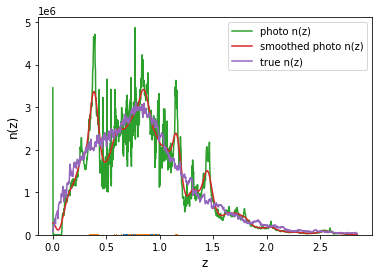

In [8]:
#load features

file_path = f'{folder}/{data_set}'
features = load_data(file_path, num_of_bins=bin_num, use_size=True, use_misclass=False)

z_phot = features['zphot'].to_numpy()
z_spec = features['specz'].to_numpy()

#calculate NMAD
phot_z_err = (z_phot-z_spec)/(1+z_spec)

median_err = np.median(phot_z_err)

deviations  = np.absolute(phot_z_err - median_err)
mad = np.median(deviations)
nmad = 1.4826*mad

#Calculate dN/dz distributions
z_max = np.max(z_phot)
spacing=1000
delta_z = z_max/spacing
z_grid, dchi_dz_grid = dchi_dz(z_max, spacing)

#for the true n(z), we need to exclude redshifts above the maximum photo-z estimate 
z_spec_cutoff = features[features['specz'] <= z_max]['specz'].to_numpy()

dN_dz_true = dN_dz(z_spec_cutoff, spacing, delta_z)
dN_dz_phot = dN_dz(z_phot, spacing, delta_z)
dN_dz_smoothed = gaussian_filter1d(dN_dz_phot, 10)
z_grid_fit = np.linspace(0, z_max, spacing)


plt.plot(z_grid_fit, dN_dz_phot, label='photo n(z)')
plt.plot(z_grid_fit, dN_dz_smoothed, label='smoothed photo n(z)')
plt.plot(z_grid_fit, dN_dz_true, label='true n(z)', )

plt.xlabel('z', fontsize=12)
plt.ylabel('n(z)', fontsize=12)

plt.legend()
plt.savefig('paper_plots/n(z)_comp_cosmodc2.png', bbox_inches='tight')
plt.show()

In [8]:
plt.close()

### Calculate SNR for different $\alpha$, $\beta$ combinations

SNR results collected into arrays so they don't need to be recalculated

In [9]:
#produces grid where rows are constant alpha!

alpha_list = [-0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0]
beta_list = [-0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0] 


In [11]:
#cosmoDC2, unsmoothed
snr_grid = np.zeros((len(alpha_list), len(beta_list)))

snr_grid[0] = [1051.58563365, 1045.68729681, 1102.48885153, 1196.83439098, 1218.88134349, 1219.38405477, 1298.38036534, 1307.19024141, 1326.30648815, 1349.784818  , 1345.01803916, 1367.6584807751672, 1349.3202272770723, 1371.3973391086133, 1358.7533635655716]
snr_grid[1] = [1263.41307661, 1314.95008787, 1382.22368819, 1400.265188, 1450.6357508, 1485.21801135, 1545.64481492, 1574.061465, 1600.50329486, 1615.84500194, 1623.43287444, 1630.1874820563, 1640.328581215506, 1639.1145849427644, 1616.4766992883372]
snr_grid[2] = [1464.38108056, 1511.18943644, 1568.61964678, 1606.8393909, 1656.30156955, 1687.1731426, 1711.33229718, 1747.64848026, 1763.84612683, 1766.75225348, 1799.37853782, 1792.1682821381378, 1779.0706621078987, 1778.3225305550998, 1779.844439006708]
snr_grid[3] = [1631.92181671, 1683.43562616, 1704.7337346, 1750.07408499, 1779.09973464, 1801.2467656, 1812.63255964, 1835.13780242, 1855.70295838, 1853.74441803, 1849.69398814, 1862.4583038145333, 1863.2916268509546, 1850.64553485593, 1858.571755699266]
snr_grid[4] = [1766.56268061, 1784.89335379, 1804.38486047, 1838.97556019, 1859.96860035, 1868.86446262, 1875.67154321, 1885.63232162, 1893.32230861, 1894.60244558, 1892.79399172, 1895.1510650902521, 1894.4082694285196, 1885.9525017878054, 1869.3732661309857]
snr_grid[5] = [1847.8368185 , 1855.86390224, 1862.24490086, 1887.97848415, 1897.83388376, 1904.84154357, 1907.14800891, 1906.94363653, 1919.24048573, 1923.4254818 , 1921.99896749, 1907.90157231243, 1897.2511728407799, 1893.871855194501, 1894.9436968919829]
snr_grid[6] = [1877.41885586, 1894.2179628 , 1898.31613563, 1904.48737665, 1921.20389853, 1930.05108515, 1932.33346686, 1932.12893813, 1924.59823363, 1929.61131634, 1929.05302522, 1919.1772176518043, 1910.9511701991191, 1903.331670682354, 1902.03112278757]
snr_grid[7] = [1908.58605204, 1910.48003598, 1913.02160517, 1919.56740222, 1934.39258001, 1941.14559705, 1944.83019453, 1938.874802  , 1934.3848859 , 1925.79579563, 1924.67280418, 1921.4385891068512, 1923.5824038454298, 1915.9293728344157, 1907.2226832832582]
snr_grid[8] = [1917.23478535, 1926.68558499, 1932.816974  , 1939.14132801, 1933.77957784, 1936.62145533, 1939.27894189, 1947.51236391, 1940.23528936, 1934.68364971, 1926.11657243, 1922.5027094014597, 1923.288628046371, 1916.5478069285841, 1915.3787398240354]
snr_grid[9] = [1930.84332644, 1937.90326888, 1947.57683568, 1938.66860866, 1934.83850751, 1931.88488437, 1934.56630917, 1941.25893403, 1946.68743119, 1939.47713875, 1933.04460257, 1926.0714865833859, 1921.8647936650825, 1919.709199545598, 1911.5495872069428]
snr_grid[10] = [1932.19220143, 1939.67390084, 1947.16749915, 1944.46745523, 1941.71534461, 1934.38109695, 1932.22875315, 1936.22264563, 1939.44600839, 1939.39823905, 1937.51896665, 1935.6450202141568, 1930.3473798240652, 1924.396677699085, 1916.3199662073694]

for i in range(len(alpha_list)):
    for j in range(len(beta_list)):
        alpha_coord = int((alpha_list[i]+0.5)/0.25)
        beta_coord = int((beta_list[j]+0.5)/0.25)
        
        if snr_grid[alpha_coord][beta_coord] > 0.001:
            print('SNR already computed: ', snr_grid[alpha_coord][beta_coord])
        else:
            print('alpha: ',alpha_list[i], ', beta: ', beta_list[j])
            M_i, M_of_z, M_edges_i, z_edges_i = bin_optimizer(z_grid, z_max, dN_dz_phot, dchi_dz_grid, alpha=alpha_list[i], beta=beta_list[j], delta_z_step=delta_z, num_of_bins=bin_num)
            results_arr = do_binning(z_phot, z_edges_i, bin_num)
            scores = get_scores(results_arr, z_spec, is_buzzard, len(z_phot), ['SNR_3x2'])
            snr_grid[alpha_coord][beta_coord] = scores['SNR_3x2']
    print(snr_grid[i])

SNR already computed:  1051.58563365
SNR already computed:  1045.68729681
SNR already computed:  1102.48885153
SNR already computed:  1196.83439098
SNR already computed:  1218.88134349
SNR already computed:  1219.38405477
SNR already computed:  1298.38036534
SNR already computed:  1307.19024141
SNR already computed:  1326.30648815
SNR already computed:  1349.784818
SNR already computed:  1345.01803916
SNR already computed:  1367.6584807751672
SNR already computed:  1349.3202272770723
SNR already computed:  1371.3973391086133
SNR already computed:  1358.7533635655716
[1051.58563365 1045.68729681 1102.48885153 1196.83439098 1218.88134349
 1219.38405477 1298.38036534 1307.19024141 1326.30648815 1349.784818
 1345.01803916 1367.65848078 1349.32022728 1371.39733911 1358.75336357]
SNR already computed:  1263.41307661
SNR already computed:  1314.95008787
SNR already computed:  1382.22368819
SNR already computed:  1400.265188
SNR already computed:  1450.6357508
SNR already computed:  1485.21801

In [12]:
#cosmoDC2 smoothed (sigma=10)
snr_grid_smoothed = np.zeros((len(alpha_list), len(beta_list)))

snr_grid_smoothed[0] = [1013.0158520147808, 1055.2687646565898, 1140.0170129832325, 1181.3884508347721, 1264.8414010944762, 1273.6520336596575, 1346.8463823075804, 1395.2576828931765, 1439.8406994075397, 1490.0278680567958, 1508.299992251844, 1533.6899166512856, 1544.8558345067884, 1565.5694332347448, 1564.220865022293]
snr_grid_smoothed[1] = [1221.5543371448748, 1291.6481402349095, 1350.195863752729, 1418.821658538057, 1461.5332078714164, 1511.9586227249183, 1561.6470222707642, 1591.3269181375529, 1631.655822357134, 1638.286914310562, 1687.5130262436292, 1677.8719371832588, 1696.6215540306584, 1700.82316268602, 1684.8290020807838]
snr_grid_smoothed[2] = [1454.2630992770805, 1506.901025782273, 1562.1689712284947, 1603.5324996333136, 1652.6083739424737, 1684.7684747094565, 1708.065436505548, 1745.2762681878692, 1762.4297390603354, 1766.021532893728, 1797.9236244993592, 1792.2709737095913, 1778.9209643519646, 1777.763431739437, 1779.4633707978564]
snr_grid_smoothed[3] = [1634.301800721582, 1682.3664661953812, 1706.3040900839817, 1756.100204198173, 1780.2359170226787, 1795, 1810.542587653888, 1835.6306883035984, 1851.1090815492612, 1845.2006948850997, 1849.180337389581, 1859.5203185253483, 1855.5928467846152, 1852.180564841841, 1852.2887978799986]
snr_grid_smoothed[4] = [1769.2363470643302, 1786.8502030728216, 1808.070462360434, 1843.3550800216597, 1861.9325291403882, 1866.785741214489, 1874.1393846227031, 1884.7159265879159, 1893.2487363492364, 1897.1597500273335, 1892.7002970711317, 1898.0685066035344, 1894.5952114635206, 1883.3317700014186, 1868.8564444122378]
snr_grid_smoothed[5] = [1849.8595580869458, 1858.2045383960408, 1864.033054364964, 1891.566483449049, 1907.7638584110618, 1907.7638584110618, 1909.6393522325632, 1911.6039404279813, 1923.1950036555038, 1925.6051314284175, 1925.3513033726938, 1908.9222004050027, 1900.376185524396, 1897.1438411285733, 1891.7543908243501]
snr_grid_smoothed[6] = [1879.0783733271774, 1897.68153700781, 1901.0705806433355, 1905.9954383939435, 1920.141011780929, 1932.242182798782, 1935.516529493412, 1935.3806517950798, 1927.3373457460928, 1932.4357382370445, 1930.6353711830095, 1921.1978092966795, 1915.620596917668, 1906.836934560945, 1903.8829165123202]
snr_grid_smoothed[7] = [1906.3446372047767, 1911.8061044605915, 1913.7081408581196, 1921.7260933539237, 1935.0122249385456, 1943.0062775665322, 1943.711917500248, 1940.8030371455409, 1933.8065885236624, 1927.4493432158076, 1925.3024909071778, 1922.7348176786495, 1924.4349930907101, 01916.0452130216167, 01905.7183189063094]
snr_grid_smoothed[8] = [1916.4261182231912, 1923.1429937979995, 1932.1094048034568, 1939.1245578727273, 1930.282169447601, 1937.5619954897431, 1939.9524204283305, 1940.0612881433274, 1938.8635560916186, 1934.3544404672646, 1925.2287326243443, 1923.1854201094188, 1916.9601770933036, 1915.8414470139405, 1911.2897550612163]
snr_grid_smoothed[9] = [1925.110360998296, 1934.462208185467, 1939.270809029177, 1934.0110874222498, 1931.3007876890408, 1939.6508654662414, 1940.3442190447063, 1933.626116779777, 1929.2136530503512, 1919.8846620590366, 1919.1363255387716, 1909.6770040044391, 1906.4026431672166, 1909.6770040044391, 1906.4026431672166]
snr_grid_smoothed[10] = [1930.5140036641376, 1925.0298549603924, 1928.8968030933981, 1934.533015349833, 1934.3063901731916, 1923.6052348792107, 1923.5270451911747, 1932.0831013810223, 1931.8029912627867, 1932.2159959131914, 1927.4621378306997, 1920.0014703790714, 1913.328424720304, 1914.2153426373025, 1904.795642108818] 

for i in range(len(alpha_list)):
    for j in range(len(beta_list)):
        alpha_coord = int((alpha_list[i]+0.5)/0.25)
        beta_coord = int((beta_list[j]+0.5)/0.25)
        
        if snr_grid_smoothed[alpha_coord][beta_coord] > 0.001:
            print('SNR already computed: ', snr_grid_smoothed[alpha_coord][beta_coord])
        else:
            print('alpha: ',alpha_list[i], ', beta: ', beta_list[j])
            M_i, M_of_z, M_edges_i, z_edges_i = bin_optimizer(z_grid, z_max, dN_dz_smoothed, dchi_dz_grid, alpha=alpha_list[i], beta=beta_list[j], delta_z_step=delta_z, num_of_bins=bin_num)
            results_arr = do_binning(z_phot, z_edges_i, bin_num)
            scores = get_scores(results_arr, z_spec, is_buzzard, len(z_phot), ['SNR_3x2'])
            snr_grid_smoothed[alpha_coord][beta_coord] = scores['SNR_3x2']
    print(snr_grid_smoothed[i])

SNR already computed:  1013.0158520147808
SNR already computed:  1055.2687646565898
SNR already computed:  1140.0170129832325
SNR already computed:  1181.3884508347721
SNR already computed:  1264.8414010944762
SNR already computed:  1273.6520336596575
SNR already computed:  1346.8463823075804
SNR already computed:  1395.2576828931765
SNR already computed:  1439.8406994075397
SNR already computed:  1490.0278680567958
SNR already computed:  1508.299992251844
SNR already computed:  1533.6899166512856
SNR already computed:  1544.8558345067884
SNR already computed:  1565.5694332347448
SNR already computed:  1564.220865022293
[1013.01585201 1055.26876466 1140.01701298 1181.38845083 1264.84140109
 1273.65203366 1346.84638231 1395.25768289 1439.84069941 1490.02786806
 1508.29999225 1533.68991665 1544.85583451 1565.56943323 1564.22086502]
SNR already computed:  1221.5543371448748
SNR already computed:  1291.6481402349095
SNR already computed:  1350.195863752729
SNR already computed:  1418.82165

In [13]:
#cosmoDC2 true n(z) unsmoothed
snr_grid_true = np.zeros((len(beta_list), len(beta_list)))

snr_grid_true[0] = [1118.100514180393, 1166.270909650038, 1235.1059663992346, 1296.838419084753, 1352.7958841013174, 1387.2443739209216, 1448.1848254161596, 1467.4849833498997, 1525.4904335028543, 1560.8264450578654, 1585.3567556682933, 1598.7404257785226, 1607.023728431968, 1594.5414625744058, 1621.9338887534311]
snr_grid_true[1] = [1282.5007162067895, 1337.3435860940733, 1410.8701252003452, 1459.872821661931, 1509.38654597119, 1553.354838576375, 1587.868570349873, 1629.637152674056, 1651.2590272742223, 1670.4815338609576, 1697.2784517698158, 1681.7215396979238, 1722.1360548313617, 1713.7615347928856, 1701.096303221527]
snr_grid_true[2] = [1451.9329054712107, 1504.9655603716578, 1559.6666230172846, 1600.7204062052426, 1649.7728141911568, 1682.159882346707, 1704.0045053109795, 1741.436329021825, 1757.1514499094174, 1760.340243295533, 1791.4245822371859, 1784.9201716170946, 1771.4744128083894, 1769.575398162506, 1770.286537686723]
snr_grid_true[3] = [1600.9517823656138, 1646.0290091530574, 1683.3353956752853, 1720.1740230653825, 1758.6285588436624, 1776.2426742953635, 1789.9067173025996, 1815.9500650061307, 1836.4239373263426, 1831.8688006074356, 1837.7089125204925, 1833.6917096318946, 1837.894835350379, 1838.805866856412, 1830.9212617652927]
snr_grid_true[4] = [1705.0463450410673, 1748.716421452257, 1775.6491035000365, 1799.310785085461, 1830.2037330442165, 1844.375098184044, 1852.697824005527, 1871.1383064265294, 1873.096378676092, 1864.707494238024, 1881.643955329633, 1883.766012167782, 1883.00223853, 1871.87825796, 1858.84115676]
snr_grid_true[5] = [1789.4456052254711, 1818.0287727285904, 1841.1071317497222, 1862.9459098974105, 1881.0171579536327, 1888.8340924486945, 1889.6078873791582, 1895.8456030835328, 1914.2311530524325, 1916.2256205135138, 1913.268112666633, 1907.083106422923, 1901.9030348605052, 1894.57663919, 1888.76373225]
snr_grid_true[6] = [1857.33594103, 1864.00401507, 1884.35955498, 1892.09381741, 1906.13453116, 1920.51907754, 1925.89930685, 1928.76483224, 1933.31676287, 1937.12495143, 1930.99278428, 1919.69026423, 1913.70123247, 1913.25028476, 1910.33930853]
snr_grid_true[7] = [1891.89536994, 1897.48288097, 1906.89843183, 1913.40451269, 1934.49849793, 1943.47768949, 1948.65866998, 1945.0067173,  1942.46566944, 1937.98647299, 1937.49789589, 1939.38430242, 1932.75821476, 1927.97222255, 1913.06380848]
snr_grid_true[8] = [1914.19683345, 1921.19943542, 1932.30377365, 1935.84527011, 1941.91804345, 1948.75804728, 1954.29736364, 1951.88205819, 1950.62255247, 1945.26204197, 1946.12466075, 1943.79903636, 1944.41441645, 1935.31712798, 1932.27105818]
snr_grid_true[9] = [1933.95646144, 1943.90317147, 1944.27525965, 1943.75644523, 1941.58843726, 1945.34448617, 1953.08411688, 1955.23476236, 1959.80625951, 1956.37580045, 1951.03561357, 1949.7534631,  1940.98513606, 1945.81218263, 1934.8902284 ]
snr_grid_true[10] = [1940.87114743, 1943.16371547, 1947.01232487, 1945.98212224, 1945.48243786, 1948.37877813, 1947.82995241, 1957.03133476, 1959.34140312, 1959.96858777, 1958.69164617, 1952.78217096, 1949.92284609, 1940.04436141, 1942.72822045] 
snr_grid_true[11] = [1936.371475657902, 1942.7604664736457, 1941.523398288335, 1947.3359297187164, 1953.8315136614551, 1950.561162242549, 1952.106737425373, 1952.5233537368686, 1957.3121782030044, 1956.4840384308534, 1960.7879874155085, 1958.6043476212685, 1951.3900189685571, 1952.768701631948, 1940.9603639230368]
snr_grid_true[12] = [1929.3731714025005, 1935.287372510442, 1942.5400862465272, 1948.9227540584163, 1951.6737896457469, 1953.1331425067424, 1953.8902084273539, 1951.660797879046, 1950.1636814407898, 1953.1010447158817, 1955.970376123202, 1958.2500466873278, 1959.327956335115, 1950.0055134, 1951.0700642]
snr_grid_true[13] = [1924.37693195, 1931.97365359, 1935.09251745, 1944.32479964, 1948.83960847, 1953.59304967, 1953.82659678, 1949.60767932, 1947.18160642, 1947.67131848, 1953.02653143, 1952.83724387, 1955.80471782, 1956.21160536, 1947.23152212]
snr_grid_true[14] = [1922.03282803, 1916.30690989, 1926.88111026, 1936.35553598, 1944.19763531, 1950.6594988,  1949.85486635, 1949.70796896, 1947.34884022, 1949.2622395, 1948.453672, 1951.48717248, 1952.36645276, 1950.35980552, 1955.35827885]

for i in range(len(alpha_list)):
    for j in range(len(beta_list)):
        alpha_coord = int((alpha_list[i]+0.5)/0.25)
        beta_coord = int((beta_list[j]+0.5)/0.25)
        
        if snr_grid_true[alpha_coord][beta_coord] > 0.001:
            print('SNR already computed: ', snr_grid_true[alpha_coord][beta_coord])
        else:
            print('alpha: ',alpha_list[i], ', beta: ', beta_list[j])
            M_i, M_of_z, M_edges_i, z_edges_i = bin_optimizer(z_grid, z_max, dN_dz_true, dchi_dz_grid, alpha=alpha_list[i], beta=beta_list[j], delta_z_step=delta_z, num_of_bins=bin_num)
            results_arr = do_binning(z_phot, z_edges_i, bin_num)
            scores = get_scores(results_arr, z_spec, is_buzzard, len(z_phot), ['SNR_3x2'])
            snr_grid_true[alpha_coord][beta_coord] = scores['SNR_3x2']
    print(snr_grid_true[i])

SNR already computed:  1118.100514180393
SNR already computed:  1166.270909650038
SNR already computed:  1235.1059663992346
SNR already computed:  1296.838419084753
SNR already computed:  1352.7958841013174
SNR already computed:  1387.2443739209216
SNR already computed:  1448.1848254161596
SNR already computed:  1467.4849833498997
SNR already computed:  1525.4904335028543
SNR already computed:  1560.8264450578654
SNR already computed:  1585.3567556682933
SNR already computed:  1598.7404257785226
SNR already computed:  1607.023728431968
SNR already computed:  1594.5414625744058
SNR already computed:  1621.9338887534311
[1118.10051418 1166.27090965 1235.1059664  1296.83841908 1352.7958841
 1387.24437392 1448.18482542 1467.48498335 1525.4904335  1560.82644506
 1585.35675567 1598.74042578 1607.02372843 1594.54146257 1621.93388875]
SNR already computed:  1282.5007162067895
SNR already computed:  1337.3435860940733
SNR already computed:  1410.8701252003452
SNR already computed:  1459.8728216

### Check if any bins are too narrow
Narrow bins are defined as narrow than the NMAD

In [14]:
alpha_too_narrow = []
beta_too_narrow = []
for i in range(len(alpha_list)):
    for j in range(len(beta_list)):
        M_i, M_of_z, M_edges_i, z_edges_i = bin_optimizer(z_grid, z_max, dN_dz_true, dchi_dz_grid, alpha=alpha_list[i], beta=beta_list[j], delta_z_step=delta_z, num_of_bins=bin_num)
        narrow = 0
        for k in range(len(z_edges_i)-1):
            if (z_edges_i[k+1] - z_edges_i[k]) < nmad:
                narrow +=1
        if narrow != 0:
            alpha_too_narrow.append(alpha_list[i])
            beta_too_narrow.append(beta_list[j])

print(alpha_too_narrow)
print(beta_too_narrow)

[]
[]


### Plot the SNRs 

Line Plots

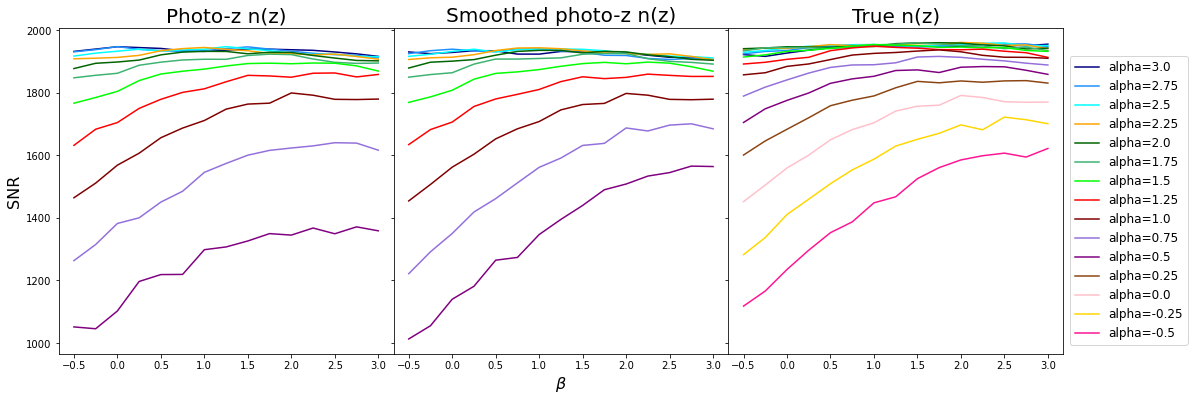

In [18]:
fig, ax = plt.subplots(1, 3, sharex='col', sharey='row', figsize=(18, 6))
colors_list = ['navy', 'dodgerblue', 'cyan', 'orange', 'darkgreen', 'mediumseagreen', 'lime', 'red', 'maroon', 'mediumpurple', 'purple', 'saddlebrown', 'pink', 'gold', 'deeppink']
for i in range(len(alpha_list)):
    k = len(alpha_list)-i-1
    ax[0].plot(beta_list, snr_grid[k], label=f'alpha={alpha_list[k]}', c=colors_list[i])
    ax[1].plot(beta_list, snr_grid_smoothed[k], label=f'alpha={alpha_list[k]}', c=colors_list[i])
for j in range(len(beta_list)):
    k = len(beta_list)-j-1
    ax[2].plot(beta_list, snr_grid_true[k], label=f'alpha={beta_list[k]}', c=colors_list[j])

ax[0].set_ylabel('SNR', fontsize=16) 
ax[1].set_xlabel(r'$\beta$', fontsize=16)

ax[0].set_title('Photo-z n(z)', fontsize=20)
ax[1].set_title('Smoothed photo-z n(z)', fontsize=20)
ax[2].set_title('True n(z)', fontsize=20)
handles, labels = ax[2].get_legend_handles_labels()
fig.legend(handles, labels, loc='center right', fontsize=12)
fig.subplots_adjust(wspace=0.0, hspace=0.0)
fig.show()

Grid Plots

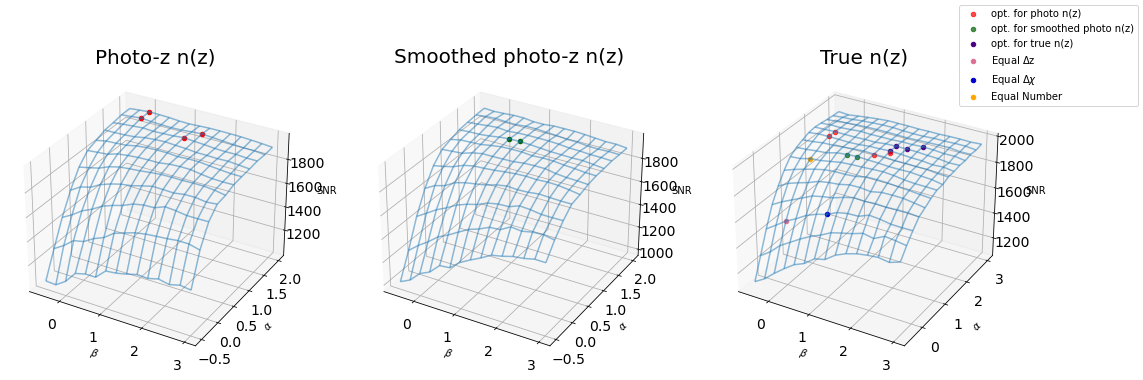

In [15]:
X = np.zeros((len(alpha_list), len(beta_list)))

for i in range(len(alpha_list)):
    for j in range(len(beta_list)):
        X[i][j] = alpha_list[i]

Y = np.zeros((len(alpha_list), len(beta_list)))

for i in range(len(alpha_list)):
    Y[i] = beta_list
    
X2 = np.zeros((len(beta_list), len(beta_list)))
Y2 = np.zeros((len(beta_list), len(beta_list)))

for i in range(len(beta_list)):
    for j in range(len(beta_list)):
        X2[i][j] = beta_list[i]
        
for i in range(len(beta_list)):
    Y2[i] = beta_list

    
from mpl_toolkits.mplot3d import Axes3D

x_max = [1.5, 1.75, 2.0, 1.75]
y_max = [1.25, 0.0, 0.0, 1.5]
snr_max = [1947.51236391, 1947.57683568, 1947.16749915, 1946.68743119]

x_max_smoothed = [1.25, 1.25]
y_max_smoothed = [0.75, 1.0]
snr_max_smoothed = [1943.00627757, 1943.7119175]

x_max_true = [1.75, 2.0, 2.0, 2.25]
y_max_true = [1.5, 1.5, 1.75, 2.0]
snr_max_true = [1959.80625951, 1959.34140312, 1959.96858777, 1960.7879874155085]

prev_binning_x = [0.0, 0.0, 1.0]
prev_binning_y = [0.0, 1.0, 0.0]
prev_binning_snr = [1559.6666230172846, 1704.0045053109795, 1884.35955498]
prev_binning_colors = ['palevioletred', 'mediumblue', 'orange']
binning_names = [r'Equal $\Delta$z', r'Equal $\Delta \chi$', r'Equal Number']

fig=plt.figure(figsize=(18,6))
ax1 = fig.add_subplot(131, projection='3d')
ax2 = fig.add_subplot(132, projection='3d')
ax3 = fig.add_subplot(133, projection='3d')


ax1.plot_wireframe(Y, X, snr_grid, alpha=0.5)
ax2.plot_wireframe(Y, X, snr_grid_smoothed, alpha=0.5)
ax3.plot_wireframe(Y2, X2, snr_grid_true, alpha=0.5)

ax1.scatter(y_max, x_max, snr_max, c='r', depthshade=False)
ax2.scatter(y_max_smoothed, x_max_smoothed, snr_max_smoothed, c='darkgreen', depthshade=False)
ax3.scatter(y_max, x_max, snr_max, c='r', depthshade=False, label='opt. for photo n(z)', alpha=0.7)
ax3.scatter(y_max_smoothed, x_max_smoothed, snr_max_smoothed, c='darkgreen', depthshade=False, label='opt. for smoothed photo n(z)', alpha=0.7)
ax3.scatter(y_max_true, x_max_true, snr_max_true, c='indigo', depthshade=False, label='opt. for true n(z)')

for i in range(len(prev_binning_x)):
    ax3.scatter(prev_binning_y[i], prev_binning_x[i], prev_binning_snr[i], c=prev_binning_colors[i], depthshade=False, label=binning_names[i])

ax1.set_xlabel(r'$\beta$')
ax1.set_ylabel(r'$\alpha$')
ax1.set_zlabel('SNR')

ax2.set_xlabel(r'$\beta$')
ax2.set_ylabel(r'$\alpha$')
ax2.set_zlabel('SNR')

ax3.set_xlabel(r'$\beta$')
ax3.set_ylabel(r'$\alpha$')
ax3.set_zlabel('SNR')

ax1.set_title('Photo-z n(z)', fontsize=20)
ax2.set_title('Smoothed photo-z n(z)', fontsize=20)
ax3.set_title('True n(z)', fontsize=20)

ax1.set_rasterized(True)
ax2.set_rasterized(True)
ax3.set_rasterized(True)

fig.legend()
fig.savefig('paper_plots/alpha_beta_comp_cosmodc2.png', bbox_inches='tight')
fig.show()

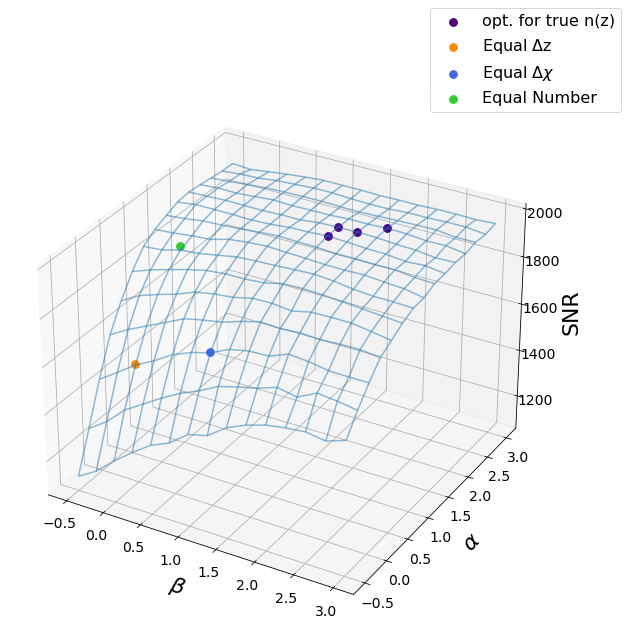

In [18]:
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 

fig=plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')

x_max_true = [1.75, 2.0, 2.0, 2.25]
y_max_true = [1.5, 1.5, 1.75, 2.0]
snr_max_true = [1959.80625951, 1959.34140312, 1959.96858777, 1960.7879874155085]

prev_binning_x = [0.0, 0.0, 1.0]
prev_binning_y = [0.0, 1.0, 0.0]
prev_binning_snr = [1563.419, 1709.155, 1899.652]

prev_binning_colors = ['darkorange', 'royalblue', 'limegreen']
binning_names = [r'Equal $\Delta$z', r'Equal $\Delta \chi$', r'Equal Number']

ax.plot_wireframe(Y2, X2, snr_grid_true, alpha=0.5)
ax.scatter(y_max_true, x_max_true, snr_max_true, c='indigo', depthshade=False, label='opt. for true n(z)', s=60)
for i in range(len(prev_binning_x)):
    ax.scatter(prev_binning_y[i], prev_binning_x[i], prev_binning_snr[i], c=prev_binning_colors[i], depthshade=False, label=binning_names[i], s=60)
    
ax.set_xlabel(r'$\beta$', fontsize=22)
ax.set_ylabel(r'$\alpha$', fontsize=22)
ax.set_zlabel('SNR', fontsize=22, rotation=90, linespacing=10) 
ax.zaxis.labelpad=10
ax.yaxis.labelpad=10
ax.xaxis.labelpad=10

fig.legend(fontsize=16)
fig.savefig('paper_plots/alpha_beta_grid_cosmodc2.pdf', bbox_inches='tight')
fig.show()

### Compare Binning Choices

In [39]:
#Lets compare equal number, equal chi, equal z and the best case.

alpha = [0.0, 0.0, 1.0, 2.25]
beta = [0.0, 1.0, 0.0, 2.0]
snr = [1559.6666230172846, 1704.0045053109795, 1884.35955498, 1960.7879874155085]

dict_of_dicts = {}
for i in range(len(alpha)):
    M_i, M_of_z, M_edges_i, z_edges_i = bin_optimizer(z_grid, z_max, dN_dz_true, dchi_dz_grid, alpha=alpha[i], beta=beta[i], delta_z_step=delta_z, num_of_bins=bin_num)
    results_arr = do_binning(z_phot, z_edges_i)
    features['bins'] = results_arr
    dict_of_dicts[f'alpha_{alpha[i]}_beta_{beta[i]}'] = make_bins(features, number_of_bins=bin_num, use_misclass=False, name_string = 'bins')
    

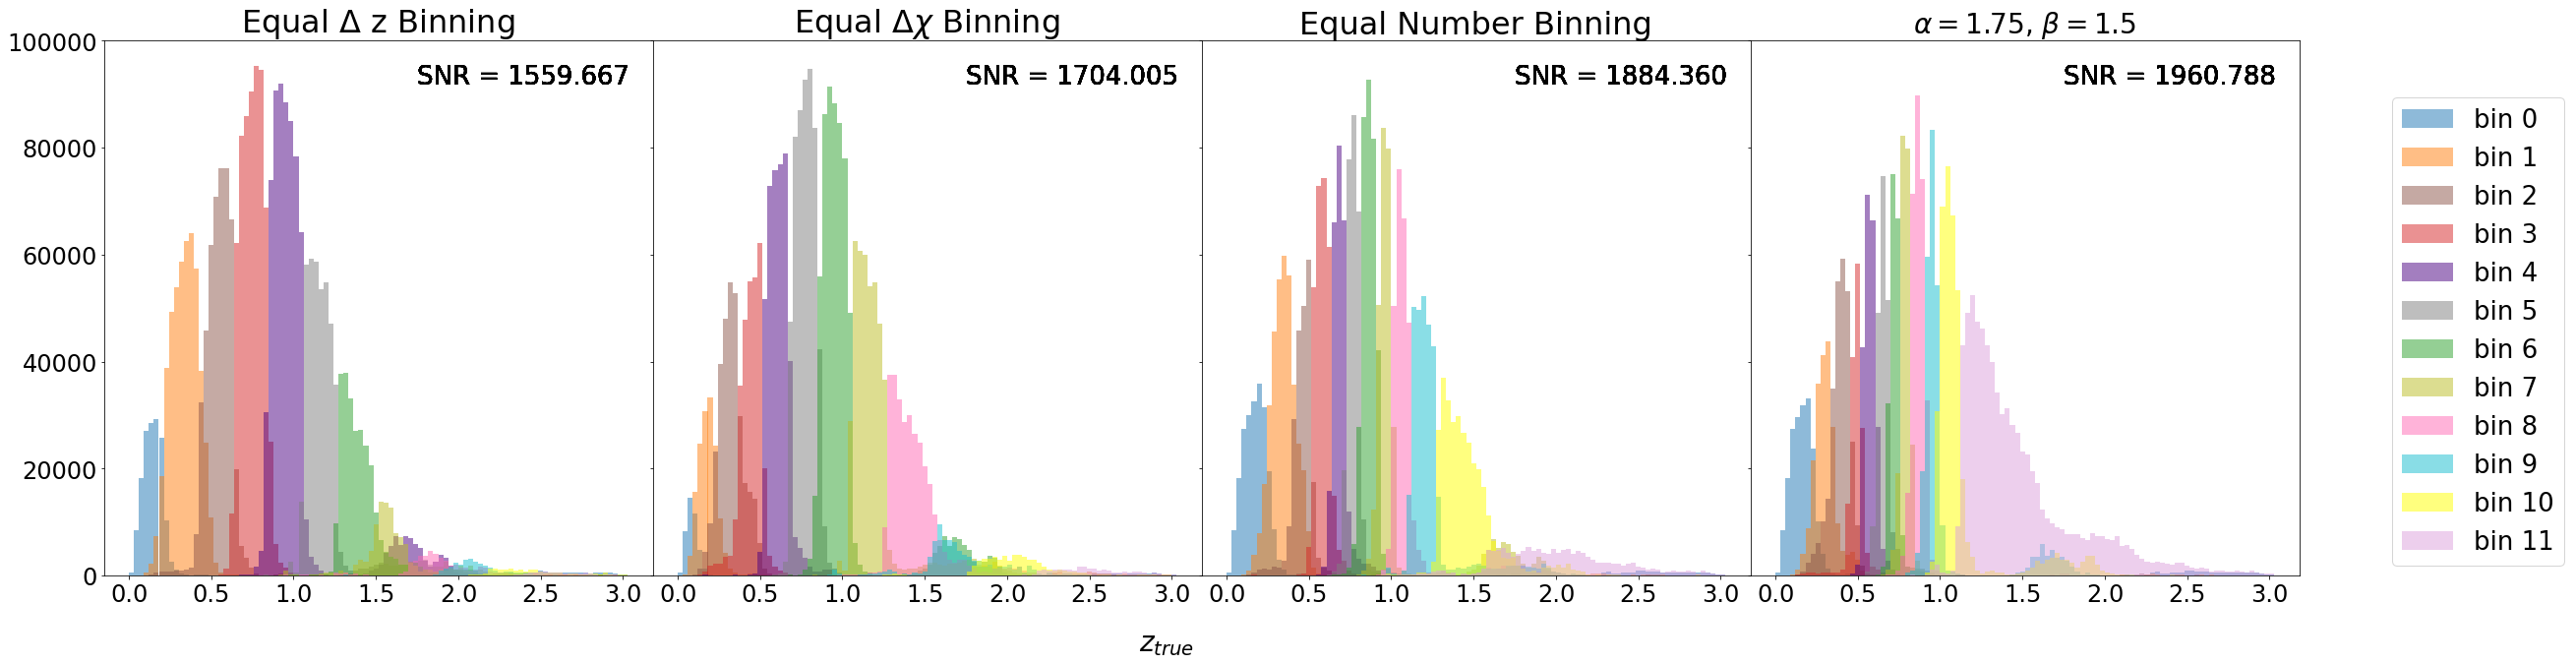

In [40]:
import matplotlib
from matplotlib.offsetbox import AnchoredText

matplotlib.rc('xtick', labelsize=24) 
matplotlib.rc('ytick', labelsize=24) 

num_rows=1
num_cols=4

text_z = AnchoredText('SNR = %.3f' % snr[0], prop=dict(size=26), frameon=False, loc='upper right')
text_chi = AnchoredText('SNR = %.3f' % snr[1], prop=dict(size=26), frameon=False, loc='upper right')
text_num = AnchoredText('SNR = %.3f' % snr[2], prop=dict(size=26), frameon=False, loc='upper right')
text_opt = AnchoredText('SNR = %.3f' % snr[3], prop=dict(size=26), frameon=False, loc='upper right')

colors_list = ['tab:blue', 'tab:orange', 'tab:brown', 'tab:red', 'indigo',  'tab:gray', 'tab:green', 'tab:olive', 'hotpink', 'tab:cyan', 'yellow', 'plum']

fig, ax = plt.subplots(num_rows, num_cols, sharex='col', sharey='row', figsize=(num_cols*10,num_rows*10))

for i in range(num_cols):
    if i == 0:
        for k in range(bin_num):
            bin_type = 'num'
            ax[i].set_title(r'Equal $\Delta$ z Binning', fontsize=32)
            ax[i].add_artist(text_z)         
                        
            bin_to_plot = dict_of_dicts['alpha_0.0_beta_0.0'][f'bin_{k}_{bin_type}']['specz'].to_numpy()
        
            ax[i].hist(bin_to_plot, 100, color=colors_list[k], alpha=0.5, range=[0,3.03], label=f'bin {k}')
        ax[i].set_rasterized(True)
                
    if i == 1:
        for k in range(bin_num):
            bin_type = 'num'
            ax[i].set_title(r'Equal $\Delta \chi$ Binning', fontsize=32)
            ax[i].add_artist(text_chi)
                        
            bin_to_plot = dict_of_dicts['alpha_0.0_beta_1.0'][f'bin_{k}_{bin_type}']['specz'].to_numpy()
        
            ax[i].hist(bin_to_plot, 100, color=colors_list[k], alpha=0.5, range=[0,3.03])
        ax[i].set_rasterized(True)
        
    if i == 2:
        for k in range(bin_num):
            bin_type = 'num'
            ax[i].set_title(r'Equal Number Binning', fontsize=32)
            ax[i].add_artist(text_num)
                        
            bin_to_plot = dict_of_dicts['alpha_1.0_beta_0.0'][f'bin_{k}_{bin_type}']['specz'].to_numpy()
        
            ax[i].hist(bin_to_plot, 100, color=colors_list[k], alpha=0.5, range=[0,3.03])
        ax[i].set_rasterized(True)
        
    if i == 3:
        for k in range(bin_num):
            bin_type = 'num'
            ax[i].set_title(r'$\alpha=2.25$, $\beta=2.0$', fontsize=28)
            ax[i].add_artist(text_opt)
                        
            bin_to_plot = dict_of_dicts[f'alpha_{alpha[i]}_beta_{beta[i]}'][f'bin_{k}_{bin_type}']['specz'].to_numpy()
        
            ax[i].hist(bin_to_plot, 100, color=colors_list[k], alpha=0.5, range=[0,3.03])
        ax[i].set_rasterized(True)

handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center right', fontsize=26)
fig.subplots_adjust(wspace=0.0, hspace=0.0)
fig.supxlabel(r'$z_{true}$', fontsize=28)
fig.subplots_adjust(wspace=0.0, hspace=0.0)

#fig.savefig('paper_plots/alpha_beta_binning_comp_cosmodc2.png', bbox_inches='tight')
fig.show()

# Step 2: Make Sample Selection Using NNCs

### Load data with misclassification NNC confidences

In [9]:
#already have features with outlier confidences
#Load misclassification features for both equal number and the optimal case
file_path_equal_num = f'{folder}/{data_set}/{misclass_equal_num_folder}'
file_path_optimal = f'{folder}/{data_set}/{misclass_optimal_folder}'
features_num = load_data(file_path_equal_num, num_of_bins=bin_num, use_size=True, use_misclass=True)
features_opt = load_data(file_path_optimal, num_of_bins=bin_num, use_size=True, use_misclass=True)

### Filter by confidence value

In [10]:
filtered_features_out, conf_thresh_out = filtering(features, retained_fraction=0.8)
filtered_features_num, conf_thresh_num = filtering(features_num, retained_fraction=0.8)
filtered_features_opt, conf_thresh_opt = filtering(features_opt, retained_fraction=0.85)

Extract redshift info

In [11]:
photz_out = filtered_features_out['zphot'].to_numpy()
specz_out = filtered_features_out['specz'].to_numpy()

photz_num = filtered_features_num['zphot'].to_numpy()
specz_num = filtered_features_num['specz'].to_numpy()

photz_opt = filtered_features_opt['zphot'].to_numpy()
specz_opt = filtered_features_opt['specz'].to_numpy()

### Make Confidence Cuts Plot

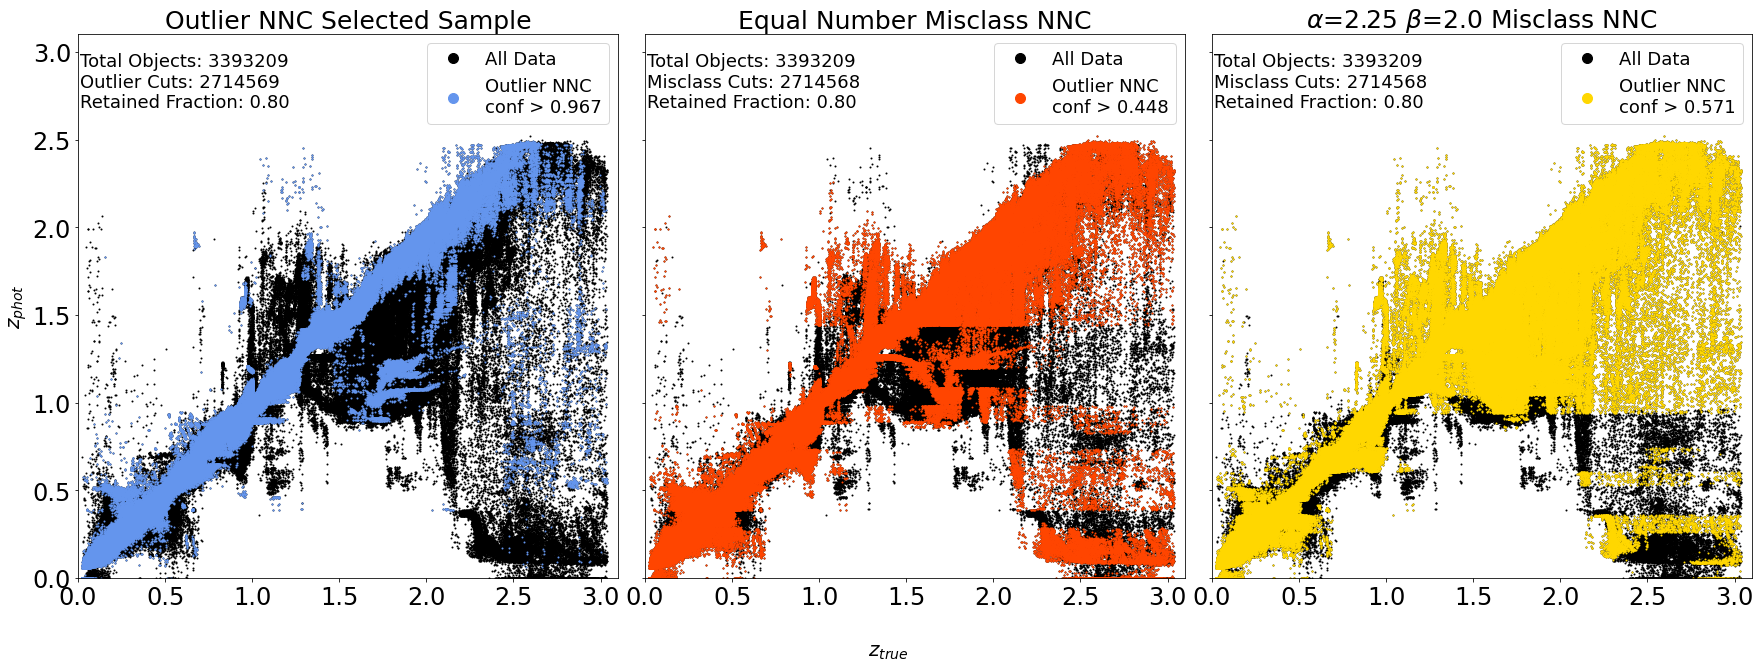

In [59]:
z_max = 3.1
text_loc_y = 3.0
text_loc_x = 0.01
legend_loc = 8
retained_frac = 0.8
        
matplotlib.rc('xtick', labelsize=24) 
matplotlib.rc('ytick', labelsize=24) 

num_rows=1
num_cols=3
x = np.linspace(0, z_max, 3)

text_out = '\n'.join(('Total Objects: %.0f' % len(z_phot), 'Outlier Cuts: %.0f' % len(photz_out), 'Retained Fraction: %.2f' %retained_frac))
text_num = '\n'.join(('Total Objects: %.0f' % len(z_phot), 'Misclass Cuts: %.0f' % len(photz_num), 'Retained Fraction: %.2f' %retained_frac))
text_opt = '\n'.join(('Total Objects: %.0f' % len(z_phot), 'Misclass Cuts: %.0f' % len(photz_opt), 'Retained Fraction: %.2f' %retained_frac))

fig, ax = plt.subplots(num_rows, num_cols, sharex='col', sharey='row', figsize=(num_cols*10,num_rows*10))

for i in range(num_cols):
    ax[i].plot(z_spec, z_phot, '.k', markersize=2, label='All Data', rasterized=True)
    ax[i].set_xlim([0, z_max])
    ax[i].set_ylim([0, z_max])
    
    if i == 0:
        ax[i].plot(specz_out, photz_out, '.', color='cornflowerblue', markersize=2, label='\n'.join(('Outlier NNC', 'conf > %.3f' % conf_thresh_out)), rasterized=True)
        ax[i].text(text_loc_x, text_loc_y, text_out, fontsize=18, verticalalignment='top')
        ax[i].set_title('Outlier NNC Selected Sample', fontsize=25)
        ax[i].set_ylabel(r'$z_{phot}$', fontsize=20)
        ax[i].legend(markerscale=10, fontsize=18)
        
    if i == 1:
        ax[i].plot(specz_num, photz_num, '.', color='orangered', markersize=2, label='\n'.join(('Outlier NNC', 'conf > %.3f' % conf_thresh_num)), rasterized=True)
        ax[i].text(text_loc_x, text_loc_y, text_num, fontsize=18, verticalalignment='top')
        ax[i].set_title('Equal Number Misclass NNC', fontsize=25)
        ax[i].legend(markerscale=10, fontsize=18)
        
    if i == 2:
        ax[i].plot(specz_opt, photz_opt, '.', color='gold', markersize=2, label='\n'.join(('Outlier NNC', 'conf > %.3f' % conf_thresh_opt)), rasterized=True)
        ax[i].text(text_loc_x, text_loc_y, text_opt, fontsize=18, verticalalignment='top')
        ax[i].set_title(r'$\alpha$=2.25 $\beta$=2.0 Misclass NNC', fontsize=25)
        ax[i].legend(markerscale=10, fontsize=18)

#figure design
fig.subplots_adjust(wspace=0.05, hspace=0.0)
fig.supxlabel(r'$z_{true}$', fontsize=20)

#fig.suptitle('Selected Samples for {} with {} Bins'.format(title_string, bin_num), fontsize=title_font, y=0.92)
#fig.savefig(f'{file_string}/{title_string}_{bin_num}_bins_retaining_{keep_frac}_individual_bins.png', bbox_inches='tight')
#fig.savefig('paper_plots/individual_bin_sample_selection_buzzard.pdf', bbox_inches='tight')

fig.show()

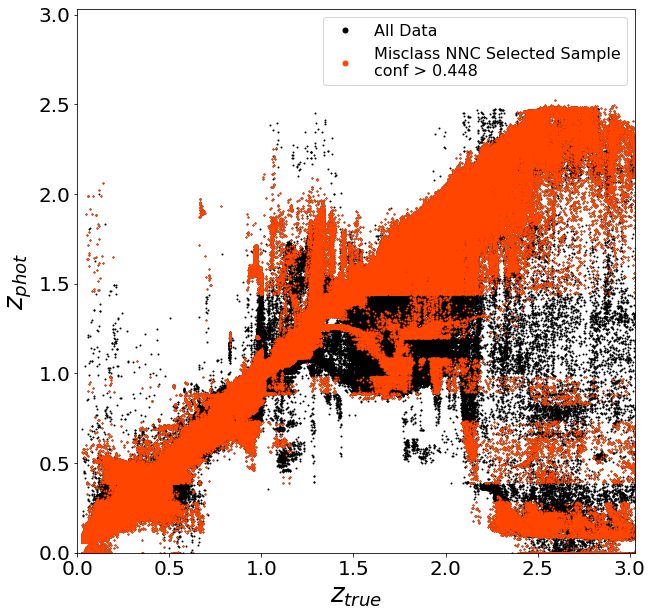

In [13]:
matplotlib.rc('xtick', labelsize=20)
matplotlib.rc('ytick', labelsize=20)
title_font = 22
axis_font = 26
text_font = 16

plt.figure(figsize=(10,10))

plt.plot(z_spec, z_phot, '.k', markersize=2, label='All Data', rasterized=True)
plt.plot(specz_num, photz_num, '.', color='orangered', markersize=2, label='\n'.join(('Misclass NNC Selected Sample', 'conf > %.3f' % conf_thresh_num)), rasterized=True)


plt.xlabel(r'$z_{true}$', fontsize=26)
plt.ylabel(r'$z_{phot}$', fontsize=26)

plt.legend(fontsize=text_font, markerscale=5)
plt.xlim([0, 3.03])
plt.ylim([0, 3.03])


plt.savefig(f'paper_plots/misclass_nnc_selected_sample.pdf', bbox_inches='tight')

plt.show()

### Calculate Outlier Fractions

In [20]:
# For full sample

del_z = np.abs((z_phot-z_spec)/(1+z_spec))

outliers = del_z[np.where(del_z > 0.15)]

len(outliers)/len(del_z)


0.050871608556973646

In [21]:
del_z_out = np.abs((photz_out-specz_out)/(1+specz_out))

outliers_out = del_z_out[np.where(del_z_out > 0.15)]

len(outliers_out)/len(del_z_out)

0.005281501409616038

# Step 3: Bin Selected Samples

### Define Bin Edges and Sort

In [13]:
bin_edges_num = bin_edges('equal_num', bin_num, z_phot)
M, M_of_z, M_edges, bin_edges_opt = bin_optimizer(z_grid, np.max(z_phot), dN_dz_true, dchi_dz_grid, alpha=2.25, beta=2.0, delta_z_step=delta_z, num_of_bins=bin_num)

results_out_num = do_binning(photz_out, bin_edges_num)
results_out_opt = do_binning(photz_out, bin_edges_opt)
results_mis_num = do_binning(photz_num, bin_edges_num)
results_mis_opt = do_binning(photz_opt, bin_edges_opt)

filtered_features_out['bins_num'] = results_out_num
filtered_features_out['bins_opt'] = results_out_opt
filtered_features_num['bins_num'] = results_mis_num
filtered_features_opt['bins_opt'] = results_mis_opt

/tmp/ipykernel_32582/4232337894.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_features_out['bins_num'] = results_out_num
/tmp/ipykernel_32582/4232337894.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_features_out['bins_opt'] = results_out_opt
/tmp/ipykernel_32582/4232337894.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://panda

### Calculate SNRs

In [14]:
scores_out_num = get_scores(results_out_num, specz_out, is_buzzard, len(z_phot), metric_list=['SNR_3x2'])
scores_out_opt = get_scores(results_out_opt, specz_out, is_buzzard, len(z_phot), metric_list=['SNR_3x2'])
scores_mis_num = get_scores(results_mis_num, specz_num, is_buzzard, len(z_phot), metric_list=['SNR_3x2'])
scores_mis_opt = get_scores(results_mis_opt, specz_opt, is_buzzard, len(z_phot), metric_list=['SNR_3x2'])

{'SNR_3x2': 1892.2468169817148}
{'SNR_3x2': 1961.5660711446535}
{'SNR_3x2': 1908.3945450593037}
{'SNR_3x2': 1972.8303861203935}


In [20]:
bins_out_num = make_bins(filtered_features_out, bin_num, name_string='bins_num')
bins_out_opt = make_bins(filtered_features_out, bin_num, name_string='bins_opt')

bins_mis_num = make_bins(filtered_features_num, bin_num, name_string='bins_num')
bins_mis_opt = make_bins(filtered_features_opt, bin_num, name_string='bins_opt')

### Make Binning Plots

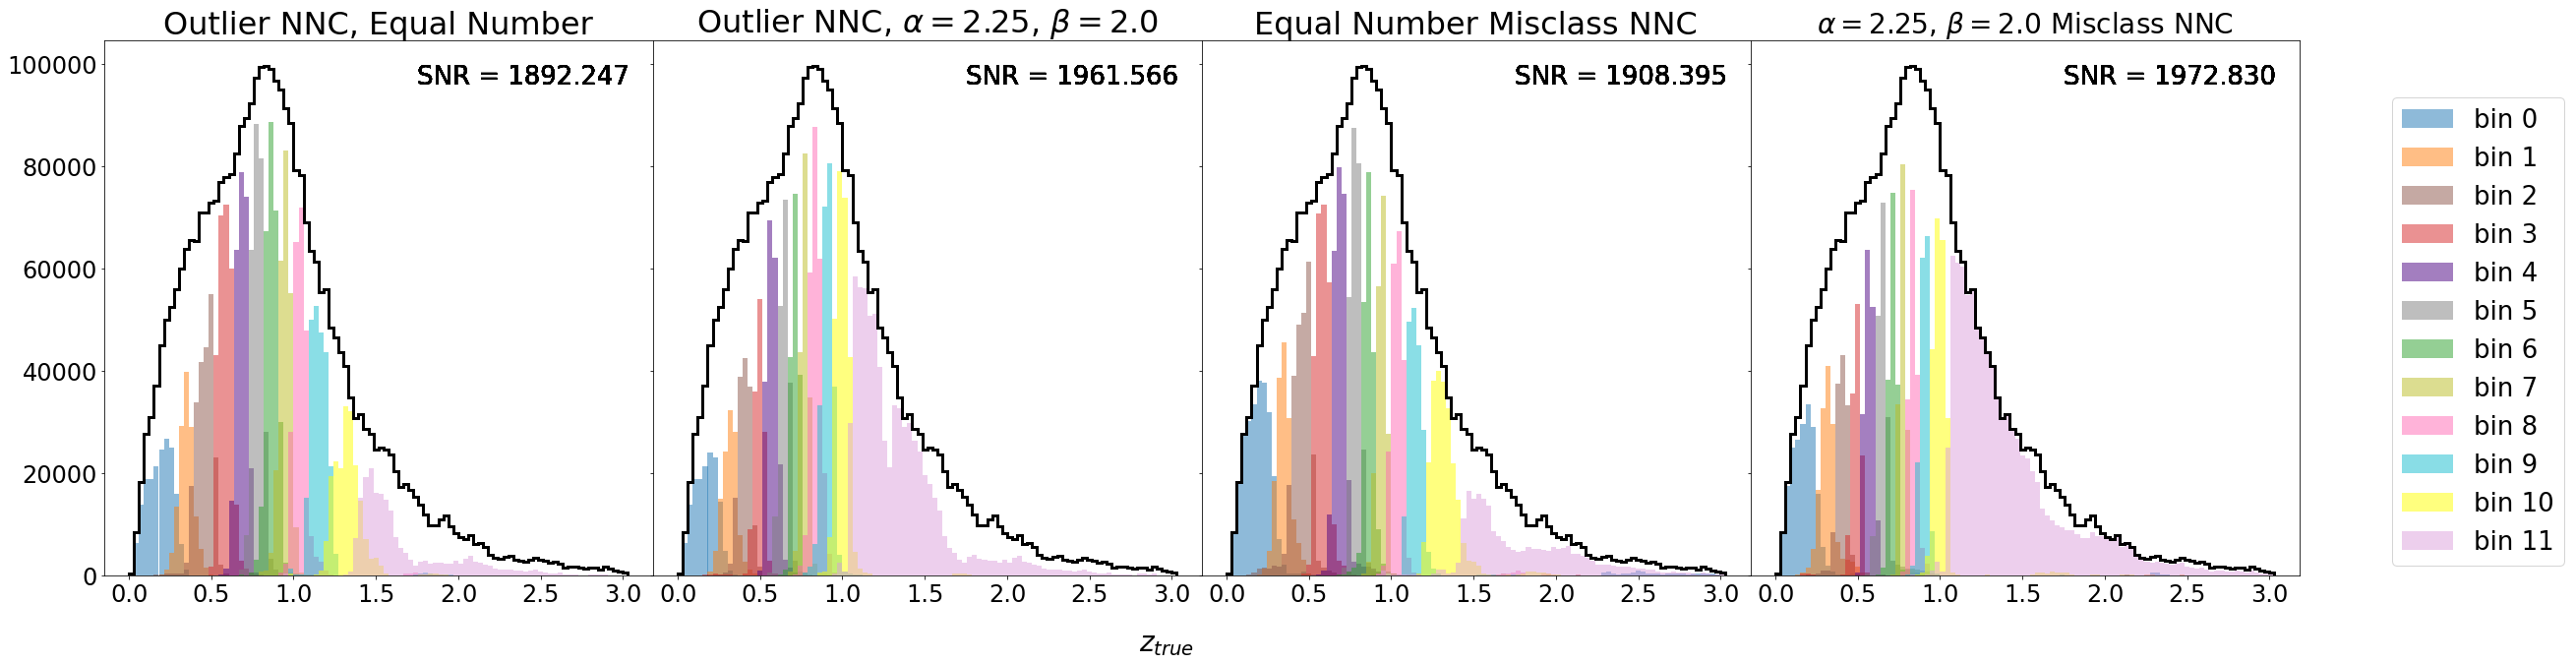

In [24]:
import matplotlib
from matplotlib.offsetbox import AnchoredText

matplotlib.rc('xtick', labelsize=24) 
matplotlib.rc('ytick', labelsize=24) 

num_rows=1
num_cols=4

text_out_num = AnchoredText('SNR = %.3f' % scores_out_num['SNR_3x2'], prop=dict(size=26), frameon=False, loc='upper right')
text_out_opt = AnchoredText('SNR = %.3f' % scores_out_opt['SNR_3x2'], prop=dict(size=26), frameon=False, loc='upper right')
text_mis_num = AnchoredText('SNR = %.3f' % scores_mis_num['SNR_3x2'], prop=dict(size=26), frameon=False, loc='upper right')
text_mis_opt = AnchoredText('SNR = %.3f' % scores_mis_opt['SNR_3x2'], prop=dict(size=26), frameon=False, loc='upper right')

colors_list = ['tab:blue', 'tab:orange', 'tab:brown', 'tab:red', 'indigo',  'tab:gray', 'tab:green', 'tab:olive', 'hotpink', 'tab:cyan', 'yellow', 'plum']

fig, ax = plt.subplots(num_rows, num_cols, sharex='col', sharey='row', figsize=(num_cols*10,num_rows*10))

N_of_z_overall = z_spec

for i in range(num_cols):
    ax[i].hist(z_spec, 100, histtype='step', range=[0,3.03], color='k', linewidth=3.0)
    if i == 0:
        for k in range(bin_num):
            bin_type = 'bins_num'
            ax[i].set_title(r'Outlier NNC, Equal Number', fontsize=32)
            ax[i].add_artist(text_out_num)         
                        
            bin_to_plot = bins_out_num[f'bin_{k}_{bin_type}']['specz'].to_numpy()
        
            ax[i].hist(bin_to_plot, 100, color=colors_list[k], alpha=0.5, range=[0,3.03], label=f'bin {k}')
        ax[i].set_rasterized(True)
                
    if i == 1:
        for k in range(bin_num):
            bin_type = 'bins_opt'
            ax[i].set_title(r'Outlier NNC, $\alpha=2.25$, $\beta=2.0$', fontsize=32)
            ax[i].add_artist(text_out_opt)
                        
            bin_to_plot = bins_out_opt[f'bin_{k}_{bin_type}']['specz'].to_numpy()
        
            ax[i].hist(bin_to_plot, 100, color=colors_list[k], alpha=0.5, range=[0,3.03])
        ax[i].set_rasterized(True)
        
    if i == 2:
        for k in range(bin_num):
            bin_type = 'bins_num'
            ax[i].set_title(r'Equal Number Misclass NNC', fontsize=32)
            ax[i].add_artist(text_mis_num)
                        
            bin_to_plot = bins_mis_num[f'bin_{k}_{bin_type}']['specz'].to_numpy()
        
            ax[i].hist(bin_to_plot, 100, color=colors_list[k], alpha=0.5, range=[0,3.03])
        ax[i].set_rasterized(True)
        
    if i == 3:
        for k in range(bin_num):
            bin_type = 'bins_opt'
            ax[i].set_title(r'$\alpha=2.25$, $\beta=2.0$ Misclass NNC', fontsize=28)
            ax[i].add_artist(text_mis_opt)
                        
            bin_to_plot = bins_mis_opt[f'bin_{k}_{bin_type}']['specz'].to_numpy()
        
            ax[i].hist(bin_to_plot, 100, color=colors_list[k], alpha=0.5, range=[0,3.03])
        ax[i].set_rasterized(True)

handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center right', fontsize=26)
fig.subplots_adjust(wspace=0.0, hspace=0.0)
fig.supxlabel(r'$z_{true}$', fontsize=28)
fig.subplots_adjust(wspace=0.0, hspace=0.0)

#fig.savefig('paper_plots/alpha_beta_binning_comp_cosmodc2.png', bbox_inches='tight')
fig.show()

# Step 4: Find Optimal Retained Fraction

In [16]:
retained_fracs = [0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.99]
snr_mis = [1943.9568890702526, 1963.518475922061, 1972.8303861203935, 1979.540819738716, 1977.2510324589816, 1962.0540302348063, 1960.7738016844967]
snr_out = [1914.6635458740575, 1942.4700900021833, 1961.5660711446535, 1973.696952804087, 1972.6796646697087, 1968.5823228351455, 1961.7490152525718]
M, M_of_z, M_edges, bin_edges_opt = bin_optimizer(z_grid, np.max(z_phot), dN_dz_true, dchi_dz_grid, alpha=2.25, beta=2.0, delta_z_step=delta_z, num_of_bins=bin_num)


for i in range(len(retained_fracs)):
    filtered_features, conf_thresh = filtering(features, retained_fracs[i])
    photz = filtered_features['zphot'].to_numpy()
    specz = filtered_features['specz'].to_numpy()
    results = do_binning(photz, bin_edges_opt)
    filtered_features['bins_opt'] = results
    scores = get_scores(results, specz, is_buzzard, len(z_phot), metric_list=['SNR_3x2'])
    snr_out.append(scores['SNR_3x2'])
    
    del(filtered_features)
    

/tmp/ipykernel_56995/1017765785.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_features['bins_opt'] = results


{'SNR_3x2': 1914.6635458740575}
{'SNR_3x2': 1942.4700900021833}
{'SNR_3x2': 1961.5660711446535}
{'SNR_3x2': 1973.696952804087}
{'SNR_3x2': 1972.6796646697087}
{'SNR_3x2': 1968.5823228351455}
{'SNR_3x2': 1961.7490152525718}


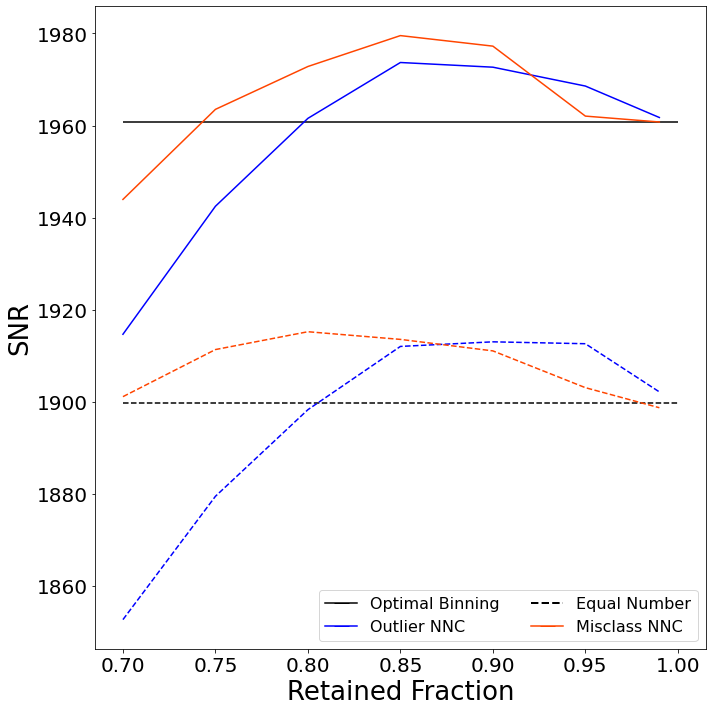

In [6]:
import matplotlib
import matplotlib.lines as mlines
retained_fracs = [0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.99]
snr_mis = [1943.9568890702526, 1963.518475922061, 1972.8303861203935, 1979.540819738716, 1977.2510324589816, 1962.0540302348063, 1960.7738016844967]
snr_out = [1914.6635458740575, 1942.4700900021833, 1961.5660711446535, 1973.696952804087, 1972.6796646697087, 1968.5823228351455, 1961.7490152525718]
snr_whole = 1960.788

snr_whole_num = 1899.652
snr_out_num = [1852.682377822797, 1879.4669176158802, 1898.2834568221867, 1912.0226596640784, 1913.021, 1912.6098750128126, 1902.1449988745965]
snr_mis_num = [1901.1093031987934, 1911.340864041743, 1915.214448288196, 1913.5503601288826, 1911.053, 1903.0637039151409, 1898.7047573002292]


matplotlib.rc('xtick', labelsize=20)
matplotlib.rc('ytick', labelsize=20)
title_font = 22
axis_font = 26
text_font = 16

plt.figure(figsize=(10,10))


plt.plot(retained_fracs, snr_out, 'b', label='Outlier NNC')
plt.plot(retained_fracs, snr_mis, 'orangered', label='Misclass NNC')
plt.hlines(snr_whole, xmin=0.7, xmax=1.0, colors='k', label='Whole Sample')

plt.plot(retained_fracs, snr_out_num, '--b', label='Outlier NNC')
plt.plot(retained_fracs, snr_mis_num, color='orangered', linestyle='dashed', label='Misclass NNC')
plt.hlines(snr_whole_num, xmin=0.7, xmax=1.0, colors='k', linestyle='dashed', label='Whole Sample')

black_line = mlines.Line2D([], [], color='k', marker='_', markersize=15, label='Outlier NNC')
dashed_line = mlines.Line2D([], [], color='k', linestyle='dashed', linewidth=2, label='Outlier NNC')
blue_line = mlines.Line2D([], [], color='b', marker='_', markersize=15, label='Outlier NNC')
red_line = mlines.Line2D([], [], color='orangered', marker='_', markersize=15, label='Misclass NNC')

plt.legend([black_line, blue_line, dashed_line, red_line], ['Optimal Binning', 'Outlier NNC', 'Equal Number', 'Misclass NNC'], ncol=2, fontsize=16)
#plt.title(r'SNR vs. Retained Fraction $\alpha=2.25$, $\beta=2.0$', fontsize=18)
plt.xlabel('Retained Fraction', fontsize=26)
plt.ylabel('SNR', fontsize=26)
plt.tight_layout()

plt.savefig(f'paper_plots/SNR_vs_retained_frac_DC2.pdf', bbox_inches='tight')

plt.show()

# Step 5: Bin each sample with the optimal retained fraction.

/global/u2/i/irenem/mydesc/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:6497: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


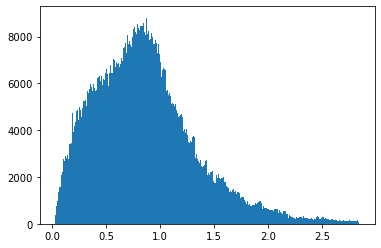

In [8]:
file_path = f'{folder}/{data_set}'
features = load_data(file_path, num_of_bins=bin_num, use_size=True, use_misclass=False)

z_phot = features['zphot'].to_numpy()
z_spec = features['specz'].to_numpy()


#Calculate dN/dz distributions
z_max = np.max(z_phot)
spacing=1000
delta_z = z_max/spacing
z_grid, dchi_dz_grid = dchi_dz(z_max, spacing)

#for the true n(z), we need to exclude redshifts above the maximum photo-z estimate 
z_spec_cutoff = features[features['specz'] <= z_max]['specz'].to_numpy()

dN_dz_true = dN_dz(z_spec_cutoff, spacing, delta_z)

In [9]:
#already have features with outlier confidences
#Load misclassification features for both equal number and the optimal case
file_path_equal_num = f'{folder}/{data_set}/{misclass_equal_num_folder}'
file_path_optimal = f'{folder}/{data_set}/{misclass_optimal_folder}'
features_num = load_data(file_path_equal_num, num_of_bins=bin_num, use_size=True, use_misclass=True)
features_opt = load_data(file_path_optimal, num_of_bins=bin_num, use_size=True, use_misclass=True)

In [10]:
filtered_features_out_num, conf_thresh_out_num = filtering(features, retained_fraction=0.9)
filtered_features_num, conf_thresh_num = filtering(features_num, retained_fraction=0.8)
filtered_features_out_opt, conf_thresh_out_opt = filtering(features, retained_fraction=0.85)
filtered_features_opt, conf_thresh_opt = filtering(features_opt, retained_fraction=0.85)

In [11]:
photz_out_num = filtered_features_out_num['zphot'].to_numpy()
specz_out_num = filtered_features_out_num['specz'].to_numpy()

photz_num = filtered_features_num['zphot'].to_numpy()
specz_num = filtered_features_num['specz'].to_numpy()

photz_out_opt = filtered_features_out_opt['zphot'].to_numpy()
specz_out_opt = filtered_features_out_opt['specz'].to_numpy()

photz_opt = filtered_features_opt['zphot'].to_numpy()
specz_opt = filtered_features_opt['specz'].to_numpy()


In [12]:
bin_edges_num = bin_edges('equal_num', bin_num, z_phot)
M, M_of_z, M_edges, bin_edges_opt = bin_optimizer(z_grid, np.max(z_phot), dN_dz_true, dchi_dz_grid, alpha=2.25, beta=2.0, delta_z_step=delta_z, num_of_bins=bin_num)

results_out_num = do_binning(photz_out_num, bin_edges_num)
results_out_opt = do_binning(photz_out_opt, bin_edges_opt)
results_mis_num = do_binning(photz_num, bin_edges_num)
results_mis_opt = do_binning(photz_opt, bin_edges_opt)

filtered_features_out_num['bins_num'] = results_out_num
filtered_features_out_opt['bins_opt'] = results_out_opt
filtered_features_num['bins_num'] = results_mis_num
filtered_features_opt['bins_opt'] = results_mis_opt

/tmp/ipykernel_37531/3045599678.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_features_out_num['bins_num'] = results_out_num
/tmp/ipykernel_37531/3045599678.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_features_out_opt['bins_opt'] = results_out_opt
/tmp/ipykernel_37531/3045599678.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https

In [13]:
del(features)

In [14]:
del(filtered_features_opt)

In [15]:
del(features_opt)

In [21]:
photz_opt

array([0.2371, 0.242 , 0.1078, ..., 1.2956, 1.0921, 2.    ])

In [13]:
results_num = do_binning(z_phot, bin_edges_num)
results_opt = do_binning(z_phot, bin_edges_opt)
                         
features['bins_num'] = results_num
features['bins_opt'] = results_opt

In [14]:
#representative training sample
scores_num = {'SNR_3x2': 1885.7762273765131}
scores_out_num = {'SNR_3x2': 1898.2375320110564}
scores_mis_num = {'SNR_3x2': 1913.3261853640158}

#Optimal Binning Scores
scores_opt = {'SNR_3x2': 1946.9038205575323}
scores_out_opt = {'SNR_3x2': 1959.5591298433342}
scores_mis_opt = {'SNR_3x2': 1984.7579751524283}

In [ ]:
scores_mis_num = get_scores(results_mis_num, specz_num, is_buzzard, len(z_phot), metric_list=['SNR_3x2'])

#Optimal Binning Scores
scores_opt = get_scores(results_opt, z_spec, is_buzzard, len(z_phot), metric_list=['SNR_3x2'])
scores_out_opt = get_scores(results_out_opt, specz_out_opt, is_buzzard, len(z_phot), metric_list=['SNR_3x2'])
scores_mis_opt = get_scores(results_mis_opt, specz_opt, is_buzzard, len(z_phot), metric_list=['SNR_3x2'])

{'SNR_3x2': 1913.3261853640158}
{'SNR_3x2': 1946.9038205575323}
{'SNR_3x2': 1959.5591298433342}


In [16]:
#Equal number binning scores
scores_num = {'SNR_3x2': 1899.652}
scores_out_num = {'SNR_3x2': 1913.021}
scores_mis_num = {'SNR_3x2': 1915.214448288196}

#Optimal Binning Scores
scores_opt = {'SNR_3x2': 1960.788}
scores_out_opt = {'SNR_3x2': 1973.696952804087}
scores_mis_opt = {'SNR_3x2': 1979.540819738716}

In [15]:
bins_out_num = make_bins(filtered_features_out_num, bin_num, name_string='bins_num')
bins_out_opt = make_bins(filtered_features_out_opt, bin_num, name_string='bins_opt')

bins_mis_num = make_bins(filtered_features_num, bin_num, name_string='bins_num')
bins_mis_opt = make_bins(filtered_features_opt, bin_num, name_string='bins_opt')

bins_num = make_bins(features, bin_num, name_string='bins_num')
bins_opt = make_bins(features, bin_num, name_string='bins_opt')

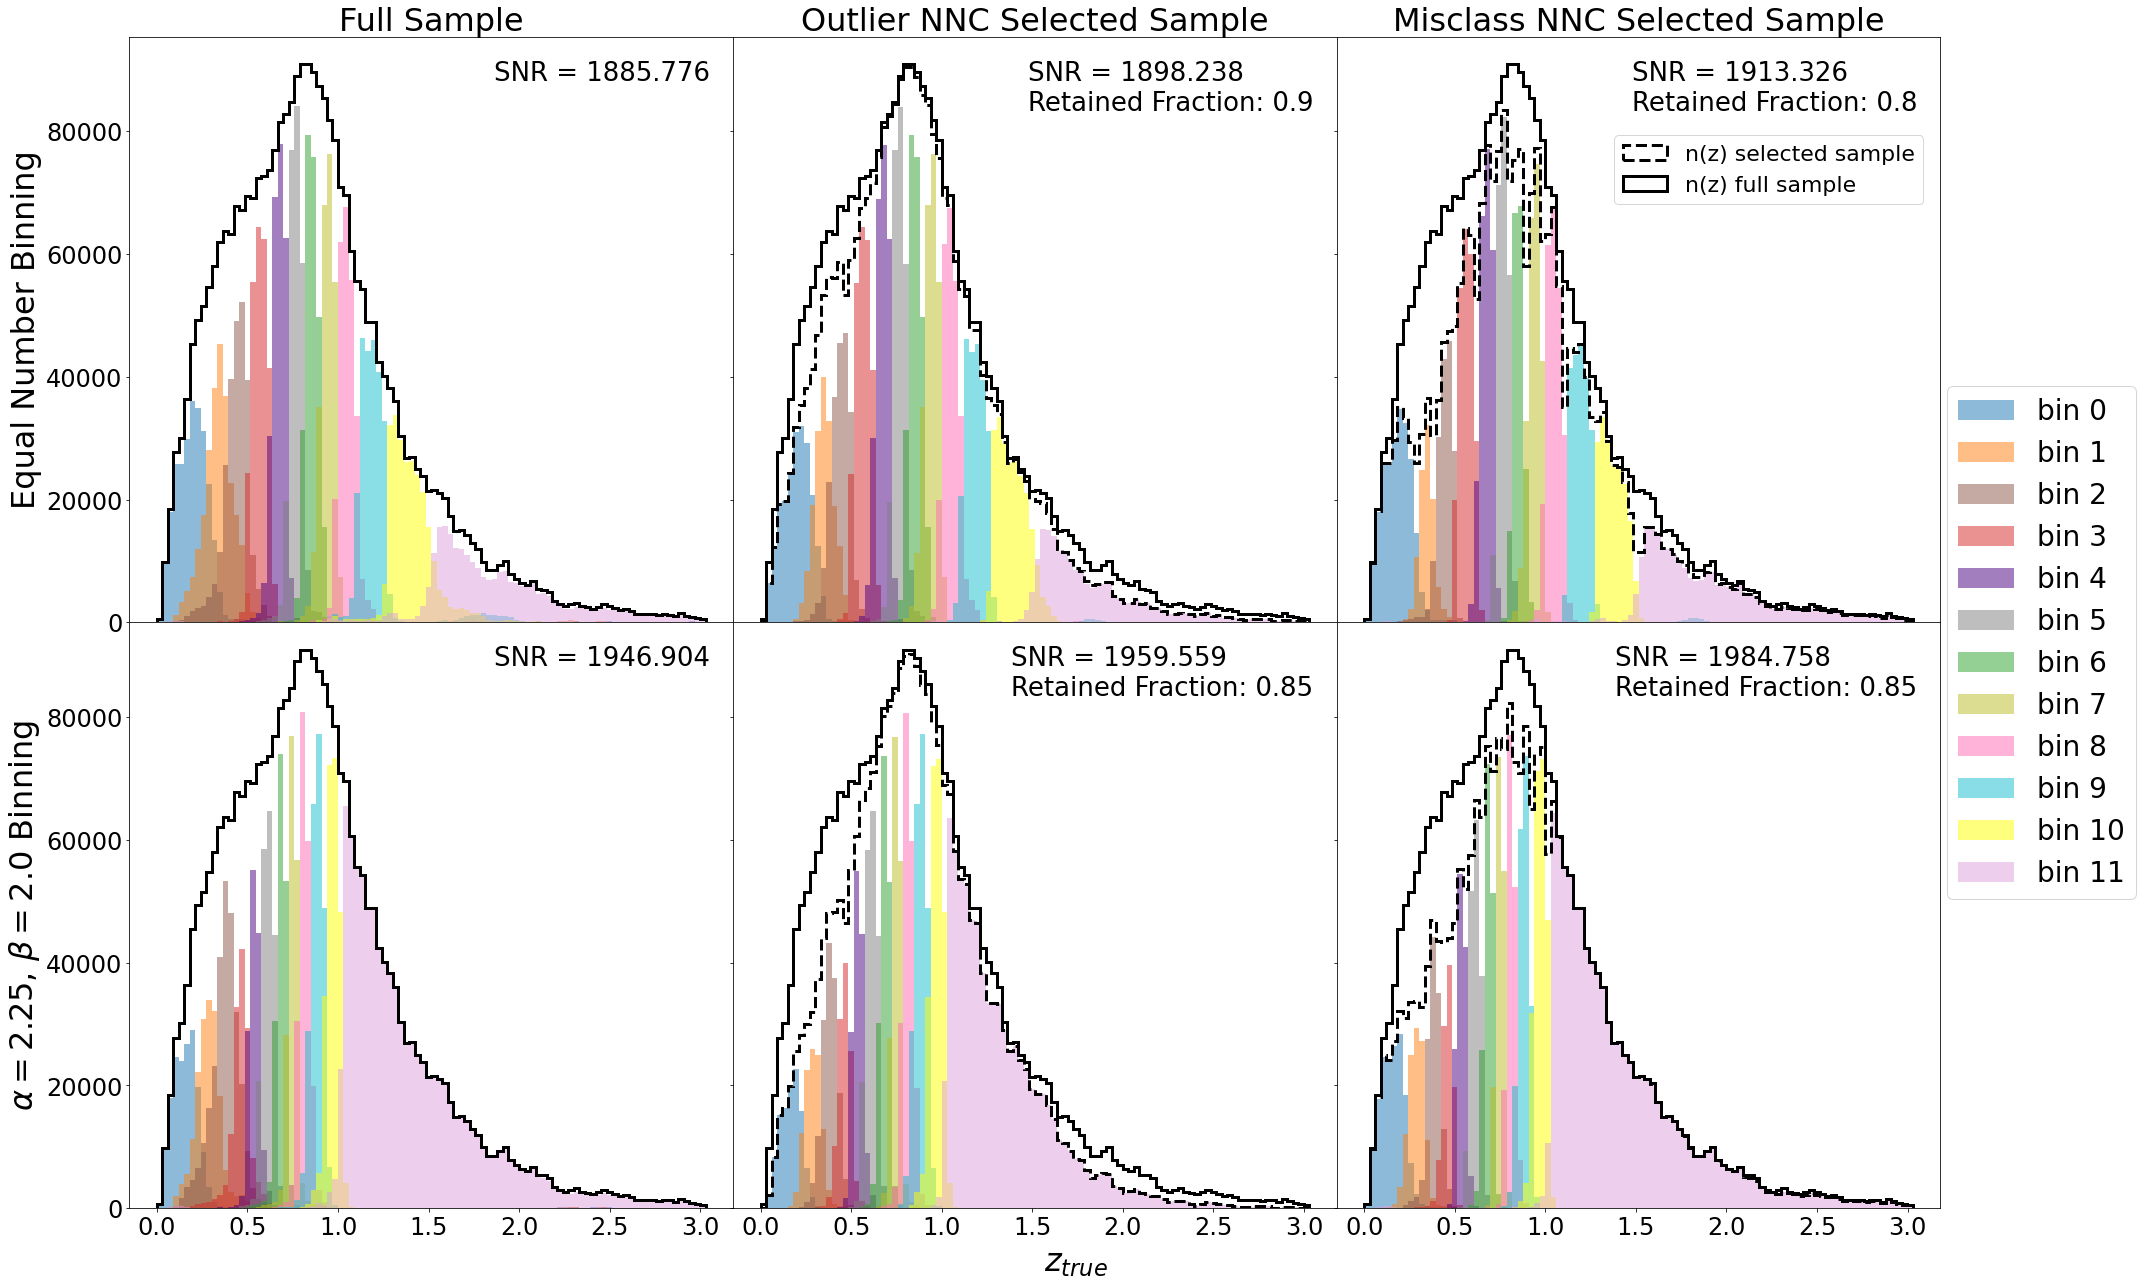

In [17]:
from matplotlib.offsetbox import AnchoredText
matplotlib.rc('xtick', labelsize=24) 
matplotlib.rc('ytick', labelsize=24) 

num_rows=2
num_cols=3

text_num = AnchoredText('SNR = %.3f' % scores_num['SNR_3x2'], prop=dict(size=26), frameon=False, loc='upper right')
text_opt = AnchoredText('SNR = %.3f' % scores_opt['SNR_3x2'], prop=dict(size=26), frameon=False, loc='upper right')
text_out_num = AnchoredText('\n'.join(('SNR = %.3f' % scores_out_num['SNR_3x2'], 'Retained Fraction: 0.9')), prop=dict(size=26), frameon=False, loc='upper right')
text_out_opt = AnchoredText('\n'.join(('SNR = %.3f' % scores_out_opt['SNR_3x2'], 'Retained Fraction: 0.85')), prop=dict(size=26), frameon=False, loc='upper right')
text_mis_num = AnchoredText('\n'.join(('SNR = %.3f' % scores_mis_num['SNR_3x2'], 'Retained Fraction: 0.8')), prop=dict(size=26), frameon=False, loc='upper right')
text_mis_opt = AnchoredText('\n'.join(('SNR = %.3f' % scores_mis_opt['SNR_3x2'], 'Retained Fraction: 0.85')), prop=dict(size=26), frameon=False, loc='upper right')

colors_list = ['tab:blue', 'tab:orange', 'tab:brown', 'tab:red', 'indigo',  'tab:gray', 'tab:green', 'tab:olive', 'hotpink', 'tab:cyan', 'yellow', 'plum']

fig, ax = plt.subplots(num_rows, num_cols, sharex='col', sharey='row', figsize=(num_cols*10,num_rows*9))

N_of_z_overall = z_spec


#top row is equal number binning
for i in range(num_cols):    
    if i == 0:
        ax[0,i].set_title(r'Full Sample', fontsize=32)
        ax[0,i].set_ylabel(r'Equal Number Binning', fontsize=32)
        ax[0,i].add_artist(text_num) 
        for k in range(bin_num):
            bin_type = 'bins_num'
            bin_to_plot = bins_num[f'bin_{k}_{bin_type}']['specz'].to_numpy()
            ax[0,i].hist(bin_to_plot, 100, color=colors_list[k], alpha=0.5, range=[0,3.03], label=f'bin {k}')
    
    if i == 1:
        ax[0,i].set_title(r'Outlier NNC Selected Sample', fontsize=32)
        ax[0,i].add_artist(text_out_num)
        for k in range(bin_num):
            bin_type = 'bins_num'
            bin_to_plot = bins_out_num[f'bin_{k}_{bin_type}']['specz'].to_numpy()
            ax[0,i].hist(bin_to_plot, 100, color=colors_list[k], alpha=0.5, range=[0,3.03], label=f'bin {k}')
        ax[0,i].hist(specz_out_num, 100, histtype='step', range=[0,3.03], color='k', linestyle='dashed', linewidth=3.0)#, label=r'n(z) selected sample')
        #ax[0,i].legend()
        
    if i == 2:
        ax[0,i].set_title(r'Misclass NNC Selected Sample', fontsize=32)
        ax[0,i].add_artist(text_mis_num)
        for k in range(bin_num):
            bin_type = 'bins_num'
            bin_to_plot = bins_mis_num[f'bin_{k}_{bin_type}']['specz'].to_numpy()
            ax[0,i].hist(bin_to_plot, 100, color=colors_list[k], alpha=0.5, range=[0,3.03])#, label=f'bin {k}')
        ax[0,i].hist(specz_num, 100, histtype='step', range=[0,3.03], color='k', linestyle='dashed', linewidth=3.0, label=r'n(z) selected sample')
        ax[0,i].hist(z_spec, 100, histtype='step', range=[0,3.03], color='k', linewidth=3.0, label=r'n(z) full sample')
        ax[0,i].legend(fontsize=22, loc='upper right', bbox_to_anchor=(0.99, 0.85))
            
#bottom row is optimal binning
for i in range(num_cols):   
    if i == 0:
        ax[1,i].set_ylabel(r'$\alpha=2.25$, $\beta=2.0$ Binning', fontsize=32)
        ax[1,i].add_artist(text_opt)
        for k in range(bin_num):
            bin_type = 'bins_opt'
            bin_to_plot = bins_opt[f'bin_{k}_{bin_type}']['specz'].to_numpy()
            ax[1,i].hist(bin_to_plot, 100, color=colors_list[k], alpha=0.5, range=[0,3.03], label=f'bin {k}')
    
    if i == 1:
        ax[1,i].add_artist(text_out_opt)
        for k in range(bin_num):
            bin_type = 'bins_opt'
            bin_to_plot = bins_out_opt[f'bin_{k}_{bin_type}']['specz'].to_numpy()
            ax[1,i].hist(bin_to_plot, 100, color=colors_list[k], alpha=0.5, range=[0,3.03], label=f'bin {k}')
        ax[1,i].hist(specz_out_opt, 100, histtype='step', range=[0,3.03], color='k', linestyle='dashed', linewidth=3.0, label=r'n(z) selected sample')
        
    if i == 2:
        ax[1,i].add_artist(text_mis_opt)
        for k in range(bin_num):
            bin_type = 'bins_opt'
            bin_to_plot = bins_mis_opt[f'bin_{k}_{bin_type}']['specz'].to_numpy()
            ax[1,i].hist(bin_to_plot, 100, color=colors_list[k], alpha=0.5, range=[0,3.03], label=f'bin {k}')
        ax[1,i].hist(specz_opt, 100, histtype='step', range=[0,3.03], color='k', linestyle='dashed', linewidth=3.0, label=r'n(z) selected sample')

for i in range(num_rows):
    for j in range(num_cols):
        ax[i,j].set_rasterized(True)
        ax[i,j].spines
        ax[i,j].hist(z_spec, 100, histtype='step', range=[0,3.03], color='k', linewidth=3.0)#, label=r'n(z) full sample')
    

fig.supxlabel(r'$z_{true}$', fontsize=32)
fig.tight_layout()
fig.subplots_adjust(wspace=0.0, hspace=0.0)
fig.subplots_adjust(right=0.9)
handles, labels = ax[0,1].get_legend_handles_labels()
fig.legend(handles, labels, loc='center right', fontsize=28)
  
fig.savefig('paper_plots/best_binning_representative_cosmodc2.pdf', bbox_inches='tight')    
fig.show()    

In [28]:
len(specz_opt)/len(z_spec)

0.5419083117525528

In [29]:
len(specz_num)/len(z_spec)

0.8000002579697331

In [30]:
conf_thresh_opt

0.3996661305427551

In [31]:
opt_conf = features_opt[features_opt['conf'] > conf_thresh_opt]

In [32]:
len(opt_conf)/len(features_opt)

0.849999772393565

In [26]:
confs = features_opt['conf'].to_numpy()

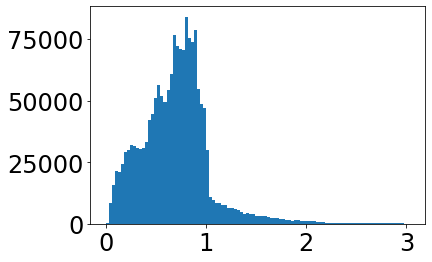

In [37]:
stuff = opt_conf['specz'].to_numpy()

plt.hist(stuff, 100)
plt.show()

In [33]:
len(filtered_features_opt)

1680533

In [38]:
opt_conf

,specz,size,g,r,i,z,y,gr,ri,iz,...,ez,ey,egr,eri,eiz,ezy,egri,eriz,eizy,conf
0,0.235807,0.12486,22.00957,21.29939,20.97291,20.74422,20.56223,0.710188,0.326472,0.228692,...,0.003206,0.006059,0.003645,0.003221,0.003957,0.006855,0.005800,0.006065,0.009121,0.430602
1,0.274469,0.13984,25.61129,24.94918,24.70803,24.52867,24.43751,0.662110,0.241144,0.179364,...,0.104637,0.215036,0.102290,0.096877,0.127213,0.239143,0.167781,0.189832,0.308659,0.554173
2,0.106646,0.26338,23.68688,23.32614,23.17685,23.09053,23.06180,0.360743,0.149288,0.086323,...,0.027825,0.060566,0.019775,0.022817,0.032955,0.066652,0.036459,0.047226,0.084124,0.999865
3,0.079301,9.92865,19.22793,18.80978,18.57568,18.45062,18.37447,0.418149,0.234109,0.125052,...,0.000388,0.000808,0.000317,0.000340,0.000464,0.000896,0.000564,0.000679,0.001148,0.998662
4,0.237762,0.24591,25.32545,24.75318,24.60269,24.48827,24.46072,0.572271,0.150483,0.114423,...,0.100815,0.219683,0.081372,0.084876,0.120311,0.241711,0.140041,0.174070,0.305330,0.669965
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1977092,1.026922,0.12888,26.06284,25.75145,25.22676,24.68478,24.65445,0.311386,0.524693,0.541983,...,0.120818,0.262595,0.180826,0.178340,0.167946,0.289056,0.317641,0.295345,0.375437,0.488151
1977093,1.202541,0.11286,25.50119,25.28961,25.02201,24.35987,24.06016,0.211576,0.267599,0.662139,...,0.089571,0.151904,0.113688,0.130784,0.131742,0.176346,0.213478,0.230492,0.253968,0.999895
1977094,1.286433,0.31125,24.34317,24.20084,24.00109,23.56230,23.18145,0.142334,0.199747,0.438785,...,0.042968,0.067622,0.040699,0.049691,0.057179,0.080118,0.078850,0.092656,0.115676,0.999972
1977095,1.114785,0.18195,30.00000,26.50569,25.66921,24.76042,24.34438,3.494310,0.836477,0.908795,...,0.129535,0.197359,30.001200,0.322108,0.218002,0.236072,30.005400,0.461270,0.369883,0.999823


In [39]:
len(features_opt)

1977097

In [40]:
len(features_num)

3101139

In [41]:
len(features_out_opt)

NameError: name 'features_out_opt' is not defined